# Fruit multiclassification

- Cavallini Francesco (920835)
- Villa Fabio (907506) 
- Perfetti Luca (919835)

Volgiamo realizzare un progetto che, letto un [dataset contenente diversi istanze di frutti ripotati di 360](https://www.kaggle.com/datasets/moltean/fruits/code), implementi un modello di rete neurale (basato su CNN) che permetta la multi calssificazione dei vari gruppi di frutta.fornita. Ossia, più nello specifico, vogliamo creare diverse istanze di reti neurali (sotto forma modalità trial and error) per arrivare a vedere quali sono le performmance più realistiche possibiili che possiamo ottenere addestrando una rete neurale per predirre due label; dove le label in questione rappresentano:
- label 1: categoria generale di frutto (eg: "apple")
- label 2: sotto-categoria di frutto (eg: "apple golden", "apple red", ...)


## Setup

Semplice sezione di setup delle librerie e del dirve

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from PIL import ImageEnhance
import random

import logging
from numpy.random import RandomState
from sklearn import cluster, decomposition
from sklearn.datasets import fetch_lfw_people
import seaborn as sns
import tensorflow as tf
from tensorflow.data import Dataset

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
from keras.layers import Input, Lambda
from tensorflow.keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import MobileNet
import cv2
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet101, VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

rng = RandomState(0)

## Lettura dataset

Dalla documentazione si evice che il dataset a nostra disposizione contiene 141 istanze di diversi frutti che vengono fatti ruotare di 360 gradi. Ma si nota che i dati a nostra disposizione non sono perfettamente integri, per questo motivo i dati vengono modificati manualmente (eliminando circa 20 classi) per garantire l'integrità dei dati. Questo step verrà meglio spiegto nella relazione. 

Di seguito procediamo con la lettura del dataset che abbiamo mantenuto:

In [2]:
dataset_path = 'Dataset\\'

### Setup dei dictionaries

Inizializzazione di dictionary che associa labels_2 (eg: "apple golden") ad un numero intero

In [3]:
# Initialize dictionaries and lists
labels_2_int = {}
labels_2_array = []
labels_1_array = []

# Counter for consecutive numbering
counter = 0

# Iterate over the subdirectories using case-insensitive sorting
for folder_name in sorted(os.listdir(dataset_path + "val\\"), key=str.lower):
    # Map folder name to an integer
    folder_name = folder_name[:-2]
    if len(folder_name.split(' ')) == 1:
        folder_name = folder_name.split(' ')[0] + " Undefined"
    
    if folder_name not in labels_2_int:
        labels_2_int[folder_name] = counter
        labels_2_array.append(folder_name)
        counter += 1
        print(folder_name)
        
    if folder_name.split(' ')[0] not in labels_1_array:
        labels_1_array.append(folder_name.split(' ')[0])

Apple Undefined
Apple Braeburn
Apple Crimson Snow
Apple Golden
Apple Granny Smith
Apple hit
Apple Pink Lady
Apple Red
Apple Red Delicious
Apple Red Yellow
Apricot Undefined
Avocado Undefined
Avocado ripe
Banana Undefined
Banana Lady Finger
Banana Red
Beetroot Undefined
Blueberry Undefined
Cabbage white
Cactus fruit
Cantaloupe Undefined
Carambula Undefined
Carrot Undefined
Cauliflower Undefined
Cherry Undefined
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut Undefined
Clementine Undefined
Cocos Undefined
Corn Undefined
Corn Husk
Cucumber Undefined
Cucumber Ripe
Dates Undefined
Eggplant Undefined
Eggplant long
Fig Undefined
Ginger Root
Granadilla Undefined
Grape Blue
Grape Pink
Grape White
Grapefruit Pink
Grapefruit White
Guava Undefined
Hazelnut Undefined
Huckleberry Undefined
Kaki Undefined
Kiwi Undefined
Kohlrabi Undefined
Kumquats Undefined
Lemon Undefined
Lemon Meyer
Limes Undefined
Lychee Undefined
Mandarine Undefined
Mango Undefined
Mango Red
Mangostan Un

Inizializzazione di un dictionary che associa labels_1 (eg: "appple") ad un numero intero

In [4]:
labels_1_int = {}
for i, fruit_name in enumerate(labels_1_array):
    # Map folder name to an integer
    labels_1_int[fruit_name] = i

Questi due dictionaries sono poi utili alla lettura del dataset, siccome, con questi possiamo assegnare ad ogni classe un intero

### Creazione dei file numpy array

#### Funzioni di modifica immagini

Siccome si ha che ogni cartella è formata da sample dello stesso oggetto frutto ma ruotato di 360 gradi, si riconosce che trainare su un dataset del genere porterebbe ad apprendere solo determinate feature di quell'ogetto ma i vari modelli non imparerebbero a generalizzare. Per questo motivo si decide di creare una seri di funzioni che inseriscono delle distorsioni dell'imagnine campione originale all'interno del dataset. Alcune di queste sono:

In [5]:
img = load_img("Dataset\\val\\Apple 6\\r0_3_100.jpg", target_size=(128, 128)) 

--------

In [6]:
def random_flip(img):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Randomly decide whether to flip along x-axis and/or y-axis
    flip_x = np.random.choice([True, False])
    flip_y = np.random.choice([True, False])
    
    if flip_x:
        img_array = np.flip(img_array, axis=1)
    if flip_y:
        img_array = np.flip(img_array, axis=0)
    
    # Convert the numpy array back to a PIL image
    flipped_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return flipped_img

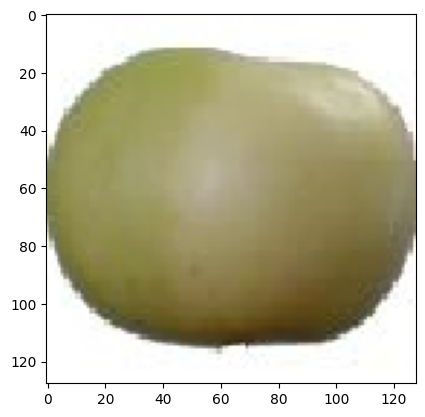

In [7]:
plt.imshow(random_flip(img))

--------

In [8]:
def translate_image(img, max_translation=60):
    # Converti l'immagine in un array numpy
    img_array = np.array(img)
    
    # Genera traslazioni casuali per x e y
    tx = np.random.randint(-max_translation, max_translation + 1)
    ty = np.random.randint(-max_translation, max_translation + 1)
    
    # Crea una nuova immagine bianca con le stesse dimensioni
    translated_img = Image.new('RGB', img.size, (255, 255, 255))
    
    # Calcola le coordinate di incollaggio
    x_offset = max(0, tx)
    y_offset = max(0, ty)
    
    # Incolla l'immagine originale nella nuova immagine traslata
    translated_img.paste(img, (x_offset, y_offset))
    
    # Ritaglia l'immagine per mantenere le dimensioni originali
    translated_img = translated_img.crop((0, 0, img.size[0], img.size[1]))
    
    return translated_img

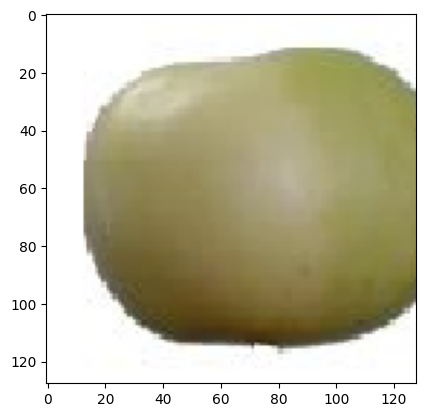

In [9]:
plt.imshow(translate_image(img))

------

In [10]:
def random_brightness(img, min_factor=0.9, max_factor=1.3):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate a random brightness factor
    brightness_factor = np.random.uniform(min_factor, max_factor)
    
    # Adjust the brightness, but do not modify pixels with value 255
    img_array = np.where(img_array < 24, np.clip(img_array * brightness_factor, 0, 255), img_array)
    
    # Convert the numpy array back to a PIL image
    bright_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return bright_img

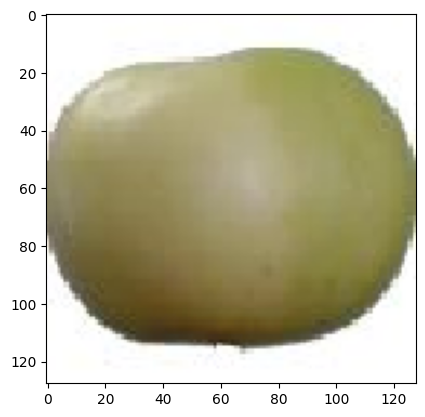

In [11]:
plt.imshow(random_brightness(img))

-----

In [12]:
def random_rgb_shift(img, max_shift=25):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate random shifts for each channel
    shift_r = np.random.randint(-max_shift, max_shift + 1)
    shift_g = np.random.randint(-max_shift, max_shift + 1)
    shift_b = np.random.randint(-max_shift, max_shift + 1)
    
    # Apply the shifts to each channel, but do not modify pixels with value 255
    img_array[..., 0] = np.where(img_array[..., 0] < 240, np.clip(img_array[..., 0] + shift_r, 0, 255), img_array[..., 0])
    img_array[..., 1] = np.where(img_array[..., 1] < 240, np.clip(img_array[..., 1] + shift_g, 0, 255), img_array[..., 1])
    img_array[..., 2] = np.where(img_array[..., 2] < 240, np.clip(img_array[..., 2] + shift_b, 0, 255), img_array[..., 2])
    
    # Convert the numpy array back to a PIL image
    shifted_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return shifted_img

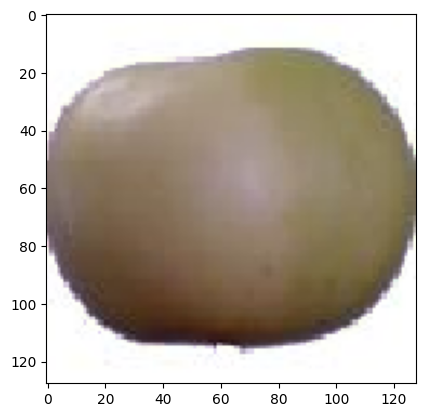

In [13]:
plt.imshow(random_rgb_shift(img))

-----

In [14]:
def random_stretch(img, max_stretch=0.07):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Get the original dimensions
    original_height, original_width = img_array.shape[:2]
    
    # Generate random stretch factors for x and y axes
    stretch_x = 1 + np.random.uniform(-max_stretch, max_stretch)
    stretch_y = 1 + np.random.uniform(-max_stretch, max_stretch)
    
    # Calculate new dimensions
    new_width = int(original_width * stretch_x)
    new_height = int(original_height * stretch_y)
    
    # Resize the image
    stretched_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Create a new white image with the original dimensions
    output_img = Image.new('RGB', (original_width, original_height), (255, 255, 255))
    
    # Calculate the position to paste the stretched image
    x_offset = (original_width - new_width) // 2
    y_offset = (original_height - new_height) // 2
    
    # Paste the stretched image onto the new white image
    output_img.paste(stretched_img, (x_offset, y_offset))
    
    return output_img

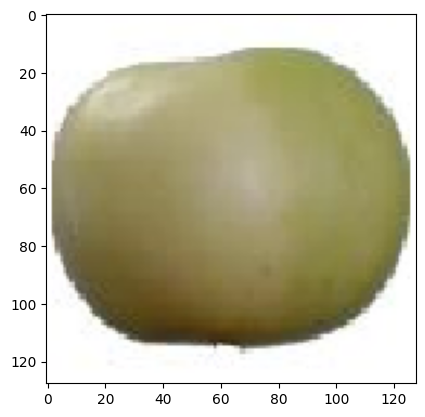

In [15]:
plt.imshow(random_stretch(img))

-----

In [16]:
def random_resize_and_repeat(img, min_scale=0.1, max_scale=0.5, num_repeats=10):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Create a white background image
    output_img = Image.new('RGB', img.size, (255, 255, 255))
    
    for _ in range(num_repeats):
        # Generate a random scale factor
        scale_factor = np.random.uniform(min_scale, max_scale)
        
        # Calculate new dimensions
        new_width = int(img.size[0] * scale_factor)
        new_height = int(img.size[1] * scale_factor)
        
        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)
        
        # Generate random position
        x_offset = np.random.randint(0, img.size[0] - new_width + 1)
        y_offset = np.random.randint(0, img.size[1] - new_height + 1)
        
        # Create a mask to handle transparency
        mask = resized_img.convert("L").point(lambda x: 0 if x > 230 else 255, mode='1')
        
        # Paste the resized image onto the white background using the mask
        output_img.paste(resized_img, (x_offset, y_offset), mask)
    
    return output_img

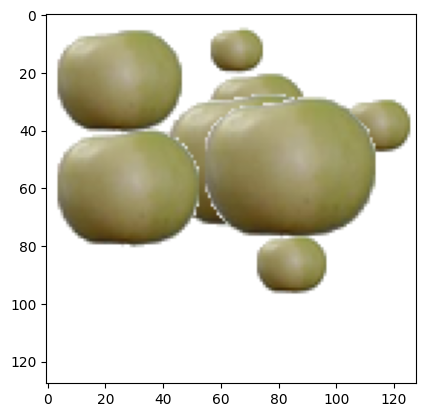

In [17]:
plt.imshow(random_resize_and_repeat(img))

#### Funzione lettura dataset

Si definisce la seguente funzione adibita a crare dei file .npz (numpy array) che serviranno successivamente a leggere l'intero dataset instantaneamente (invece che dover attendere lunghi tempi di attesa solo per caricare il dataset)

In [18]:
def preprocess_and_save(input_dir, output_file, show_images=False, augmentation=False):
    data = []
    # categoria generale (es mela)
    labels_1 = []
    # categoria specifica (es mela golden)
    labels_2 = []

    # support variables for plotting
    already_printed = []
    images_to_plot = []
    labels_to_plot = []

    class_names = sorted(os.listdir(input_dir))  # Assicura ordine costante delle classi
    for _, class_name in enumerate(class_names):
        class_dir = os.path.join(input_dir, class_name)

        # Use os.path.split to correctly handle path separators in a platform-independent way
        _, folder_name = os.path.split(class_dir)

        label_1 = labels_1_int[folder_name.split(' ')[0]]  # Access label_1
        
        folder_name = folder_name[:-2]
        if(len( folder_name.split(' ') ) == 1):
            folder_name = folder_name.split(' ')[0] + " Undefined"
        print(folder_name)
        label_2 = labels_2_int[folder_name]                # Access label_2

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path)  # Ridimensiona
            
            if(augmentation):
            # Genera un numero casuale da uno a 10
                random_number = random.randint(1, 10)
                # Switch del numero con case vuoti
                if random_number == 1:
                    pass  # Case vuoto
                elif random_number == 2:
                    img = translate_image(img)
                elif random_number == 3:
                    pass  # nothing
                elif random_number == 4:
                    img = random_brightness(img)
                elif random_number == 5:
                    pass  # Case vuoto
                elif random_number == 6:
                    img = random_stretch(img)
                elif random_number == 7:
                    img = random_resize_and_repeat(img)
                elif random_number == 8:
                    img = random_flip(img)
                elif random_number == 9:
                    img = random_rgb_shift(img)
                elif random_number == 10:
                    pass  # Case vuoto
            
            img_array = img_to_array(img)  # Convert the image to a NumPy array before resizing
            #img_array = cv2.resize(img_array, (128, 128), interpolation=cv2.INTER_CUBIC)
            data.append(img_array)
            labels_1.append(label_1)
            labels_2.append(label_2)

            # Store image and label for plotting
            if label_2 not in already_printed:
                images_to_plot.append(img)
                labels_to_plot.append(folder_name)  # Use folder_name directly
                already_printed.append(label_2)

    if show_images:
        # Plot images and labels
        num_images = len(images_to_plot)
        num_cols = 10
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(20, num_rows * 2))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(images_to_plot[i])
            plt.title(labels_to_plot[i])
            plt.axis('off')
        plt.show()
        #save image to file
        plt.savefig('plot.png')

    # Converti in array numpy
    data = np.array(data)
    labels_1 = np.array(labels_1)
    labels_2 = np.array(labels_2)

    # Controllo se è train o validation per applicare lo shuffle
    if 'train' in input_dir:
        indices = np.random.permutation(len(data))  # Genera indici casuali
        data = data[indices]
        labels_1 = labels_1[indices]
        labels_2 = labels_2[indices]
        print("shuffle eseguito")
    else:
        print("shuffle solo per il train")

    # Salva i dati
    np.savez(output_file, x=data, y1=labels_1, y2=labels_2)

Di seguito viene chimata la funzione per creare i file di train/test/validation sets:

#### Scelta di utilizzo aumentation

In [19]:
needs_augmentation = True
npz_prefix = "Regular_NPZ\\"
if(needs_augmentation):
    npz_prefix = "Augmented_NPZ\\"

#### File train

Nota che in questo caso viene anche plottato un grafico che mostra un sample per ogni frutto disponibile nel nostro dataset. Questo plot è stato poi salvato in memoria di modo da porter comunque venire visualizzato anche quando non si esegue la funzione mostrata precedentemente:

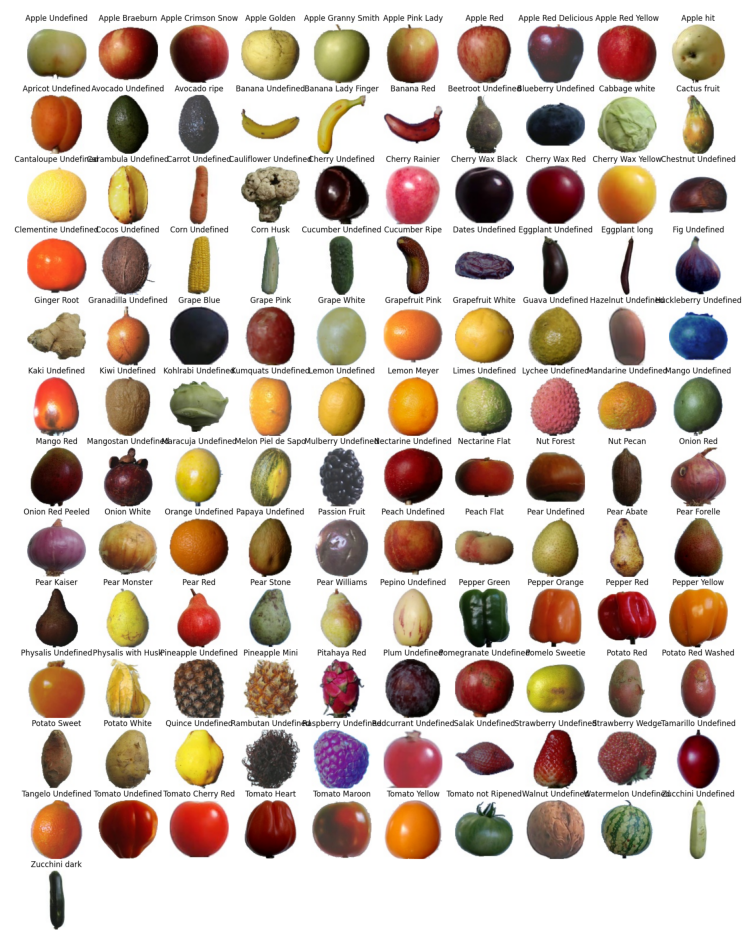

In [20]:
train_path = npz_prefix+'train_data_BIG_AUG.npz'
# check if npz file already exists
if not os.path.exists(train_path):
    preprocess_and_save(dataset_path+'train', train_path, show_images=True)
else:
    # plot local image using plt
    img = mpimg.imread('plot.png')
    # Create a figure with a large size
    fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed

    # Display the image
    ax.imshow(img)

    # Maximize the axis size by turning off the spines and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the image
    plt.show()

#### File validazione

scrittura file validation set con la stessa funzione

In [21]:
val_path = npz_prefix+'val_data_BIG_AUG.npz'
# check if npz file already exists
if not os.path.exists(val_path):
    preprocess_and_save(dataset_path+'val', val_path)

#### File test

scrittura file test set con la stessa funzione

In [22]:
test_path = npz_prefix+'test_data_BIG_AUG.npz'
# check if npz file already exists
if not os.path.exists(test_path):
    preprocess_and_save(dataset_path+'test', test_path)

### Lettura file numpy array

Una volta che i file numpy array sono stati salvati è possibile leggerli direttamente, avere lo step precedente che ci salva tutti i dati in formato file e poi leggerli in questo step rende la lettura compilazione del file molto lenta (cosa che non ci interessa perchè dobbiamo farlo una sola volta) ma la lettura di tutto il dataset molto veloce.

In [23]:
def load_data():
    # load train data
    data_train = np.load(npz_prefix+'train_data_BIG_AUG.npz')
    x_train, y1_train, y2_train = data_train['x'], data_train['y1'], data_train['y2']

    # Load validation data
    data_val = np.load(npz_prefix+'val_data_BIG_AUG.npz')
    x_val, y1_val, y2_val = data_val['x'], data_val['y1'], data_val['y2']

    # Load test data
    data_test = np.load(npz_prefix+'test_data_BIG_AUG.npz')
    x_test, y1_test, y2_test = data_test['x'], data_test['y1'], data_test['y2']

    return x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test

In [24]:
x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test = load_data()

In [25]:
for i in range(10):
    print(f"train {i+1}: {labels_1_array[y1_train[i]]}, {labels_2_array[y2_train[i]]}")

train 1: Tomato, Tomato Undefined
train 2: Mulberry, Mulberry Undefined
train 3: Eggplant, Eggplant Undefined
train 4: Pear, Pear Forelle
train 5: Cherry, Cherry Undefined
train 6: Quince, Quince Undefined
train 7: Cantaloupe, Cantaloupe Undefined
train 8: Apple, Apple Golden
train 9: Physalis, Physalis Undefined
train 10: Apple, Apple Golden


### Pre-Processing: one-hot-encoding delle label

Per ora le label precedentemente salvate sono state create in formato numerico (classe "apple"-->0, classe "pear"-->1, ...). In questa sezione si procede con il one-hot di tutte le label, che, in teoria, dovrebbe migliorare le perfomance di train in quanto abbiamo così che tutti i dati di label sono compresi nel range [0-1]

In [ ]:
def onehot_all_labels():
    # onehot label1
    y1_train = to_categorical(y1_train, num_classes=70)
    y1_val = to_categorical(y1_val, num_classes=70)
    y1_test = to_categorical(y1_test, num_classes=70)

    # onehot label2
    y2_train = to_categorical(y2_train, num_classes=121)
    y2_val = to_categorical(y2_val, num_classes=121)
    y2_test = to_categorical(y2_test, num_classes=121)

    return y1_train, y1_val, y1_test, y2_train, y2_val, y2_test

In [ ]:
y1_train, y1_val, y1_test, y2_train, y2_val, y2_test = onehot_all_labels()

Si sceglie di applicare direttamente questo step in fase di lettura dei dati in quanto non comporta alcuna modifica significativa al valore informativo delle informazioni, tutti i dati possono venire comunque letti come se non avesssimo fatto alcuna modifica.

## Anlisi esplorativa

Prima di procedere con la preparazione dei dati si fa' una breve analisi esplorativa, per osservare se ci sono alcune incoformità nel dataset precedentemente processato e per cercare attributi particolari che magari hanno bisono di essere sistemati in fase di preparazione dati pre-train.

### Numero di classi

Abbiamo dunque che il numero di classi per i 2 tipi di label:

In [27]:
num_object_label_1 = y1_train.shape[1]
num_object_label_2 = y2_train.shape[1]
print(f"Numero di classi per label_1: {num_object_label_1}")
print(f"Numero di classi per label_2: {num_object_label_2}")

Numero di classi per label_1: 70
Numero di classi per label_2: 121


### Studio bilanciamento dataset

In particolare, se andiamo ad esplorare il numero di dati presenti per ogni label e sotto-label otteniamo il seguente albero:

In [28]:
# Contiamo il numero di occorrenze per ogni etichetta secondaria
y2_counts = np.sum(y2_train, axis=0)  # Conta le occorrenze di ogni classe secondaria

# Creiamo una struttura ad albero
root = Node("Frutti")  # Nodo radice
primary_nodes = {}

# Aggiungi nodi per le label primarie
for primary_label in labels_1_int:
    primary_nodes[primary_label] = Node(f"{primary_label} (0)", parent=root)

# Aggiungi nodi per le label secondarie con conteggio
for class_name, index in labels_2_int.items():
    primary_label = class_name.split(' ')[0]  # Estrarre la label primaria
    count = int(y2_counts[index])  # Numero di occorrenze per questa classe
    if primary_label in primary_nodes:
        Node(f"{class_name} ({count})", parent=primary_nodes[primary_label])

# Aggiorna i conteggi delle label primarie
for primary_label, node in primary_nodes.items():
    total_count = sum(
        int(child.name.split("(")[-1].strip(")")) for child in node.children
    )
    node.name = f"{primary_label} ({total_count})"

# Stampa l'albero con conteggi
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

Frutti
├── Apple (6069)
│   ├── Apple Undefined (379)
│   ├── Apple Braeburn (394)
│   ├── Apple Crimson Snow (356)
│   ├── Apple Golden (1163)
│   ├── Apple Granny Smith (394)
│   ├── Apple hit (562)
│   ├── Apple Pink Lady (365)
│   ├── Apple Red (1132)
│   ├── Apple Red Delicious (392)
│   └── Apple Red Yellow (932)
├── Apricot (394)
│   └── Apricot Undefined (394)
├── Avocado (735)
│   ├── Avocado Undefined (342)
│   └── Avocado ripe (393)
├── Banana (1144)
│   ├── Banana Undefined (392)
│   ├── Banana Lady Finger (360)
│   └── Banana Red (392)
├── Beetroot (360)
│   └── Beetroot Undefined (360)
├── Blueberry (370)
│   └── Blueberry Undefined (370)
├── Cabbage (116)
│   └── Cabbage white (116)
├── Cactus (392)
│   └── Cactus fruit (392)
├── Cantaloupe (788)
│   └── Cantaloupe Undefined (788)
├── Carambula (392)
│   └── Carambula Undefined (392)
├── Carrot (121)
│   └── Carrot Undefined (121)
├── Cauliflower (562)
│   └── Cauliflower Undefined (562)
├── Cherry (2758)
│   ├── Cherry 

Osservando i dati euristicamente sembra che ogni sotto-classe (label_2) abbia più o meno lo stesso numero di sample (circa 300), mentre invece il numero di sample per le classi principali (label) è molto più sbilanciato.  Procediamo quindi a a possiamo studiare più nel dettaglio la distrubuzione di classi e sottoclassi con la seguente funzione:

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(y_train, label_names, title="Distribuzione delle etichette"):
    """
    Visualizza la distribuzione delle etichette in un dataset.
    
    :param y_train: array numpy (one-hot encoded)
    :param label_names: lista dei nomi delle classi
    :param title: titolo del grafico
    """
    # Converti one-hot encoding in indici delle classi
    class_indices = np.argmax(y_train, axis=1)  # Trova la classe con valore massimo

    # Conta la frequenza di ogni classe
    label_counts = Counter(class_indices)

    # Estrai etichette e frequenze
    labels = [label_names[idx] for idx in label_counts.keys()]
    values = list(label_counts.values())

    # Imposta la figura con due sottotrame
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Diagramma a torta
    axes[0].pie(values, labels=labels, startangle=90, colors=plt.cm.tab20.colors, autopct='%1.1f%%')
    axes[0].set_title(f"{title} (Pie Chart)")
    axes[0].axis('equal')  # Assicura che il diagramma sia un cerchio

    # Diagramma a barre
    axes[1].bar(labels, values, color=plt.cm.tab20.colors[:len(labels)])
    axes[1].set_title(f"{title} (Bar Chart)")
    axes[1].set_xlabel("Etichette")
    axes[1].set_ylabel("Frequenza")
    axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Rimuove le etichette

    # Mostra il grafico
    plt.tight_layout()
    plt.show()

### Studio delle frequenze per label_2 (sotto-classe)

In [30]:
# Plot distribuzione di y2_train
label_names_y2 = list(labels_2_int.keys())  # Nomi per y2
plot_label_distribution(y2_train, label_names_y2, title="Distribuzione di Y2 (Sottoclassi)")

Dai grafici appena mostrati ci possiamo ricredere, risulta infatti eviddente (specialmente dal diagramma a barre) che seppur la maggior parte delle classi abbia un numero vicino alle 350 istanze ci sono comunque molte altre classi che hanno o un numero minore di 350 samples o maggiore di 350. Queste venngono meglio visualizzate nel prossimo plot:

In [ ]:
# Converti one-hot encoding in indici delle classi
class_indices = np.argmax(y2_train, axis=1)

# Conta le occorrenze di ogni classe
class_counts = Counter(class_indices)

# Filtra le classi con meno di 250 e più di 350 immagini
class_over_350 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count > 350}
class_under_250 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count < 250}

# Imposta la figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Grafico per le classi con più di 350 immagini
axes[0].bar(class_over_350.keys(), class_over_350.values(), color='green')
axes[0].set_xlabel('Classi')
axes[0].set_ylabel('Numero di immagini')
axes[0].set_title('Classi con più di 350 immagini')
axes[0].tick_params(axis='x', rotation=90)

# Grafico per le classi con meno di 250 immagini
axes[1].bar(class_under_250.keys(), class_under_250.values(), color='red')
axes[1].set_xlabel('Classi')
axes[1].set_title('Classi con meno di 250 immagini')
axes[1].tick_params(axis='x', rotation=90)

# Mostra il grafico
plt.tight_layout()
plt.show()

Dal grafico risulta evidente che ci siamo molte sotto-classi che hanno più di 350 sample e potrebbero portare ad una classificazione sbilanciata. Allo stesso modo, seppur in numero minore, la stessa ossrevazione vale anche per le classi undersamplate.

Per questo motivo potrebbe dunque essere sensato nella fase di preparazione dati potremmo pensare di fare il calcolo dei pesi da assegnare a ciascuna classe per evitare di avere una classificazione spilanciata

### Studio frequenze per label_1 (classe principale)

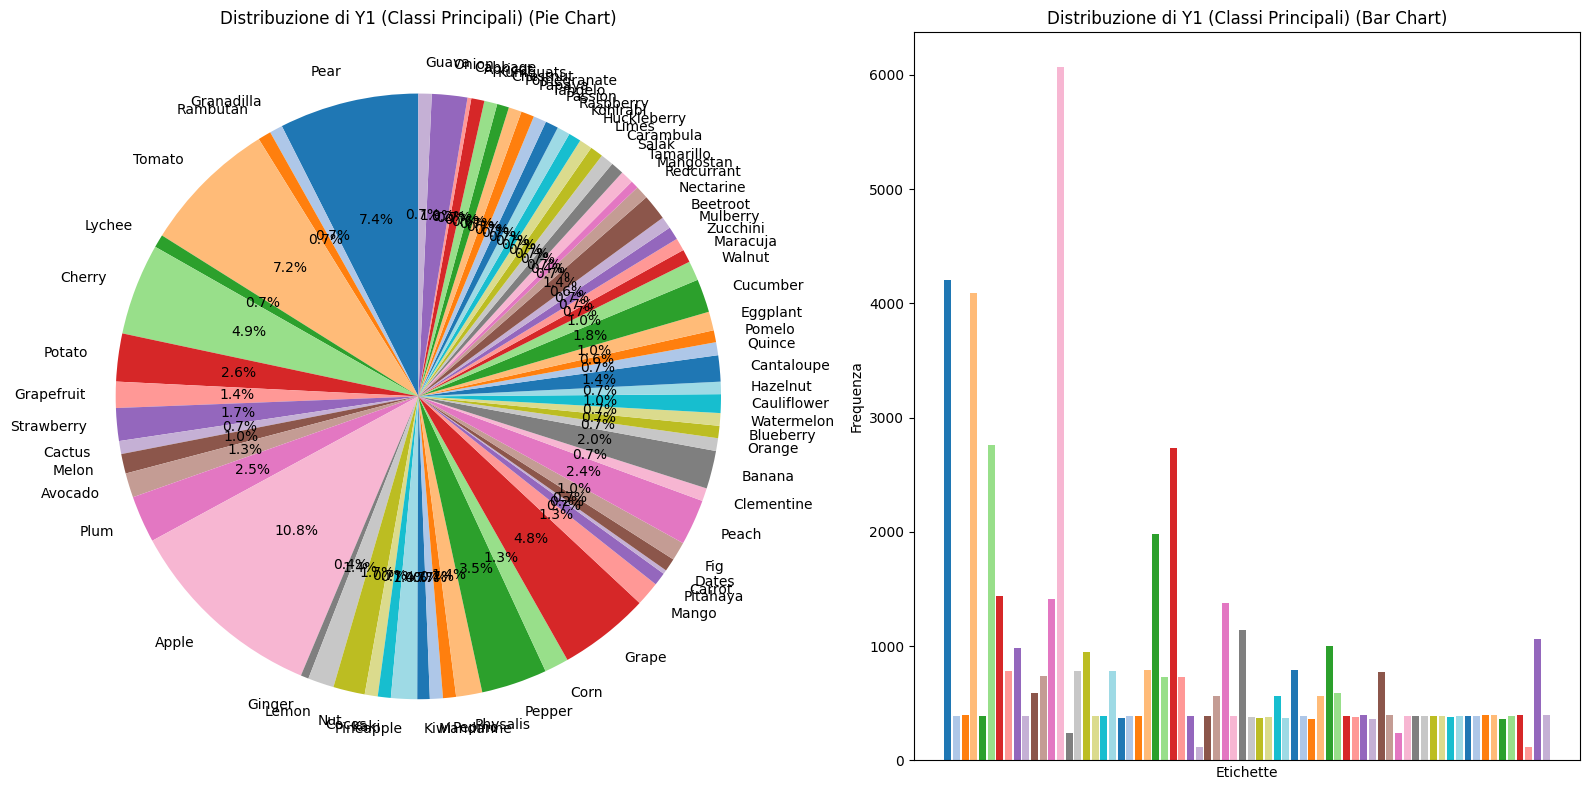

In [32]:
# Plot distribuzione di y1_train
label_names_y1 = list(labels_1_int.keys())  # Nomi per y1
plot_label_distribution(y1_train, label_names_y1, title="Distribuzione di Y1 (Classi Principali)")

In questo caso la differenza di esempi per ogni classe diventa molto più evidente, anche senza bisogno di fare un'analisi più dettagliata come per le label precedenti, per questo motivo si decide di calcolare dei pesi da assegnare a ciascuna classe anche per questa label

## Preparazione dei dati

Questo step è già stato in gran parte svolto nel momento in cui si è definita la funzione che salva i file npz. Abbiamo infatti che in questa funzione ci si assicura anche che tutte le immaigni vengano salvate con la stessa dimensione standard (100,100). Inoltre è anche già stato fatto il one-hot delle labels in fase di pre-processing. Di conseguenza, non ci rimangono altre operazioni da fare se non controlloare l'uniformità di tutti i dati caricati.

### Controllo conformità dati

In [ ]:
def check_data_conformity(x, y1, y2, dataset_name="train"):
    errors = []
    
    # 1 Controllo dimensione dataset
    num_samples = x.shape[0]
    
    if y1.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y1 ha {y1.shape[0]} campioni, ma x ne ha {num_samples}")
    
    if y2.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y2 ha {y2.shape[0]} campioni, ma x ne ha {num_samples}")
    
    # 2️ Controllo se le etichette sono one-hot encoded
    if len(y1.shape) != 2:
        errors.append(f"❌ {dataset_name}: y1 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y1.shape}")
    
    if len(y2.shape) != 2:
        errors.append(f"❌ {dataset_name}: y2 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y2.shape}")

    # Se non ci sono errori, tutto è conforme
    if not errors:
        print(f"✅ {dataset_name}: Tutti i dati sono conformi!")
    else:
        for error in errors:
            print(error)

In [ ]:
check_data_conformity(x_train, y1_train, y2_train,dataset_name="Train")
check_data_conformity(x_val, y1_val, y2_val, dataset_name="Validation")
check_data_conformity(x_test, y1_test, y2_test, dataset_name="Test")

✅ Train: Tutti i dati sono conformi!
✅ Validation: Tutti i dati sono conformi!
✅ Test: Tutti i dati sono conformi!


### Funzione relaod di tutti i dati

Siccome quando si esegue nomralizzazione tramite i metodi di keras passando i file di train e test questi vengono passati per riferimento e vengono modificati è necessario ri-caricare i corretti valori di train test e val datasets. Per precauzione aggiuntiva questa operazione viene ripetuta prima dell'esecuzione di ciascun modello.

In [ ]:
def reaload_from_scratch():
    x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test = load_data()
    y1_train, y1_val, y1_test, y2_train, y2_val, y2_test = onehot_all_labels()
    return x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test

## Costruzione dei modelli

**Nota**: per velocizzare il train ed evitare di overfitatre sui dati di train, si sceglie di impostare un valore di steps per epochs uguale a: $$ \frac{ 150\% \text{ dell'intero dataset}} {\text{numero di epoche}} $$In questo modo si ha che per ogni singola epoca si visiterà in totale solo una frazione del dataset; invece che avere che per ogni singola epoca far visitare tutto il set. 
Questo porta ad avere che la loss potrebbe avere comportamenti fluttuanti (scendi / sali) quando si scoprono per la prima volta sample che non sono mai stati esplorati in epoche precedenti.

### Modello 0: CNN custom (Baseline)

#### Normalizzazione dati:

Come vedremo ogni modello pre-trainato richiede una fase di normalizzazione a se stante, quindi per evitare di combinare erroneamente queste elaborazioni diverse sulle stesse variabili ogni modello dovrà implementare la sua normalizzazione:

In [ ]:
# Preprocessing per train
x_train = x_train / 255.0

# Preprocessing per validation
x_val = x_val / 255.0

# Preprocessing per test
x_test = x_test / 255.0

#### Function graph

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 18))  # Aumento l'altezza per adattare più subplot

    # Grafico della Loss totale
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Total Loss')

    # Grafico della Loss Y1 (Fruit)
    plt.subplot(3, 2, 2)
    plt.plot(epochs, history.history['y1_loss'], 'b-', label='Y1 (Fruit) Loss')
    plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Y1 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Y1 (Fruit) Loss')

    # Grafico della Loss Y2 (Quality)
    plt.subplot(3, 2, 3)
    plt.plot(epochs, history.history['y2_loss'], 'g-', label='Y2 (Quality) Loss')
    plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Y2 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Y2 (Quality) Loss')

    # Grafico della Accuracy Y1 (Fruit)
    plt.subplot(3, 2, 4)
    plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Y1 (Fruit) Accuracy')
    plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Y1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Y1 (Fruit) Accuracy')

    # Grafico della Accuracy Y2 (Quality)
    plt.subplot(3, 2, 5)
    plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Y2 (Quality) Accuracy')
    plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Y2 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Y2 (Quality) Accuracy')

    # Grafico della Accuracy Totale
    total_accuracy = (np.array(history.history['y1_accuracy']) + np.array(history.history['y2_accuracy'])) / 2
    val_total_accuracy = (np.array(history.history['val_y1_accuracy']) + np.array(history.history['val_y2_accuracy'])) / 2

    plt.subplot(3, 2, 6)
    plt.plot(epochs, total_accuracy, 'm-', label='Total Accuracy')
    plt.plot(epochs, val_total_accuracy, 'm--', label='Val Total Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Total Accuracy')

    plt.tight_layout()  # Migliora la disposizione dei grafici
    plt.show()


#### Calcolo steps per epochs

In [ ]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])

In [ ]:
dataset_size = len(x_train)  # Numero totale di campioni
epochs_number = 100
batch_size = 32

steps_per_epoch = int(1.5 * dataset_size / batch_size / epochs_number)
steps_per_val = int(len(x_val) / batch_size / epochs_number)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Steps per val: {steps_per_val}")

Steps per epoch: 26
Steps per val: 7


#### Implementazione CNN

In [ ]:
# Definizione della CNN
inputs = Input(shape=input_shape)

x = Conv2D(64, (9, 9), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output 1: Predizione del Frutto
fruit_output = Dense(num_classes_1, activation='softmax', name='y1')(x)

# Output 2: Predizione della Qualità
quality_output = Dense(num_classes_2, activation='softmax', name='y2')(x)


In [ ]:
# Modello finale
model = Model(inputs=inputs, outputs=[fruit_output, quality_output])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 92, 92,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 46, 46,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 46, 46,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 23, 23,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 11, 11,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1 (Dense)          │ (None, 70)        │      9,030 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2 (Dense)          │ (None, 121)       │     15,609 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 442,175 (1.69 MB)

 Trainable params: 442,175 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilazione
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss={
            'y1': 'categorical_crossentropy',
            'y2': 'categorical_crossentropy'
        },
    metrics={
        'y1': 'accuracy', 
        'y2': 'accuracy'
        }
)

#### Train del modello:

In [ ]:
if(os.path.exists('keras/model-CNN.keras')):
    model = load_model('keras/model-CNN.keras')
else:
    history = model.fit(
        x_train,
        {
            'y1': y1_train,
            'y2': y2_train
        },
        validation_data=(
            x_val,
            {
                'y1': y1_val,
                'y2': y2_val
            }
        ),
        epochs=epochs_number,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_val
    )

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 894ms/step - loss: 8.9519 - y1_accuracy: 0.0783 - y1_loss: 4.1210 - y2_accuracy: 0.0043 - y2_loss: 4.8309 - val_loss: 7.8146 - val_y1_accuracy: 0.1328 - val_y1_loss: 2.8335 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.9811
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - loss: 8.6026 - y1_accuracy: 0.0922 - y1_loss: 3.8794 - y2_accuracy: 0.0209 - y2_loss: 4.7232 - val_loss: 7.5716 - val_y1_accuracy: 0.2734 - val_y1_loss: 2.8521 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.7195
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - loss: 8.3837 - y1_accuracy: 0.1648 - y1_loss: 3.7783 - y2_accuracy: 0.0528 - y2_loss: 4.6054 - val_loss: 7.6581 - val_y1_accuracy: 0.5938 - val_y1_loss: 2.7480 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.9101
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - loss: 8.3100 - y1_accuracy: 0.1208 - y1_loss: 3.7350 - y2_accuracy: 0.0467 - y2_loss: 4.5750 - val_loss: 7.8373 - val_y1_accuracy: 0.0078 - val

/Users/lucaperfetti/Desktop/università/Secondo Anno/Advanced ML/Project/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - loss: 2.4909 - y1_accuracy: 0.6512 - y1_loss: 1.2288 - y2_accuracy: 0.6241 - y2_loss: 1.2619 - val_loss: 2.1217 - val_y1_accuracy: 0.8789 - val_y1_loss: 0.7421 - val_y2_accuracy: 0.6367 - val_y2_loss: 1.3797
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - loss: 2.2063 - y1_accuracy: 0.6646 - y1_loss: 1.1293 - y2_accuracy: 0.6747 - y2_loss: 1.0770 - val_loss: 2.6595 - val_y1_accuracy: 0.7266 - val_y1_loss: 0.9806 - val_y2_accuracy: 0.5508 - val_y2_loss: 1.6789
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - loss: 2.1878 - y1_accuracy: 0.6791 - y1_loss: 1.0872 - y2_accuracy: 0.6805 - y2_loss: 1.1006 - val_loss: 2.5876 - val_y1_accuracy: 0.6602 - val_y1_loss: 0.9269 - val_y2_accuracy: 0.3984 - val_y2_loss: 1.6607
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - loss: 2.2820 - y1_accuracy: 0.6366 - y1_loss: 1.1508 - y2_accuracy: 0.6581 - y2_loss: 1.1312 - val_loss: 3.0653 - val_y1_accuracy: 0.4492 - val_y1_loss: 1.3510 - val

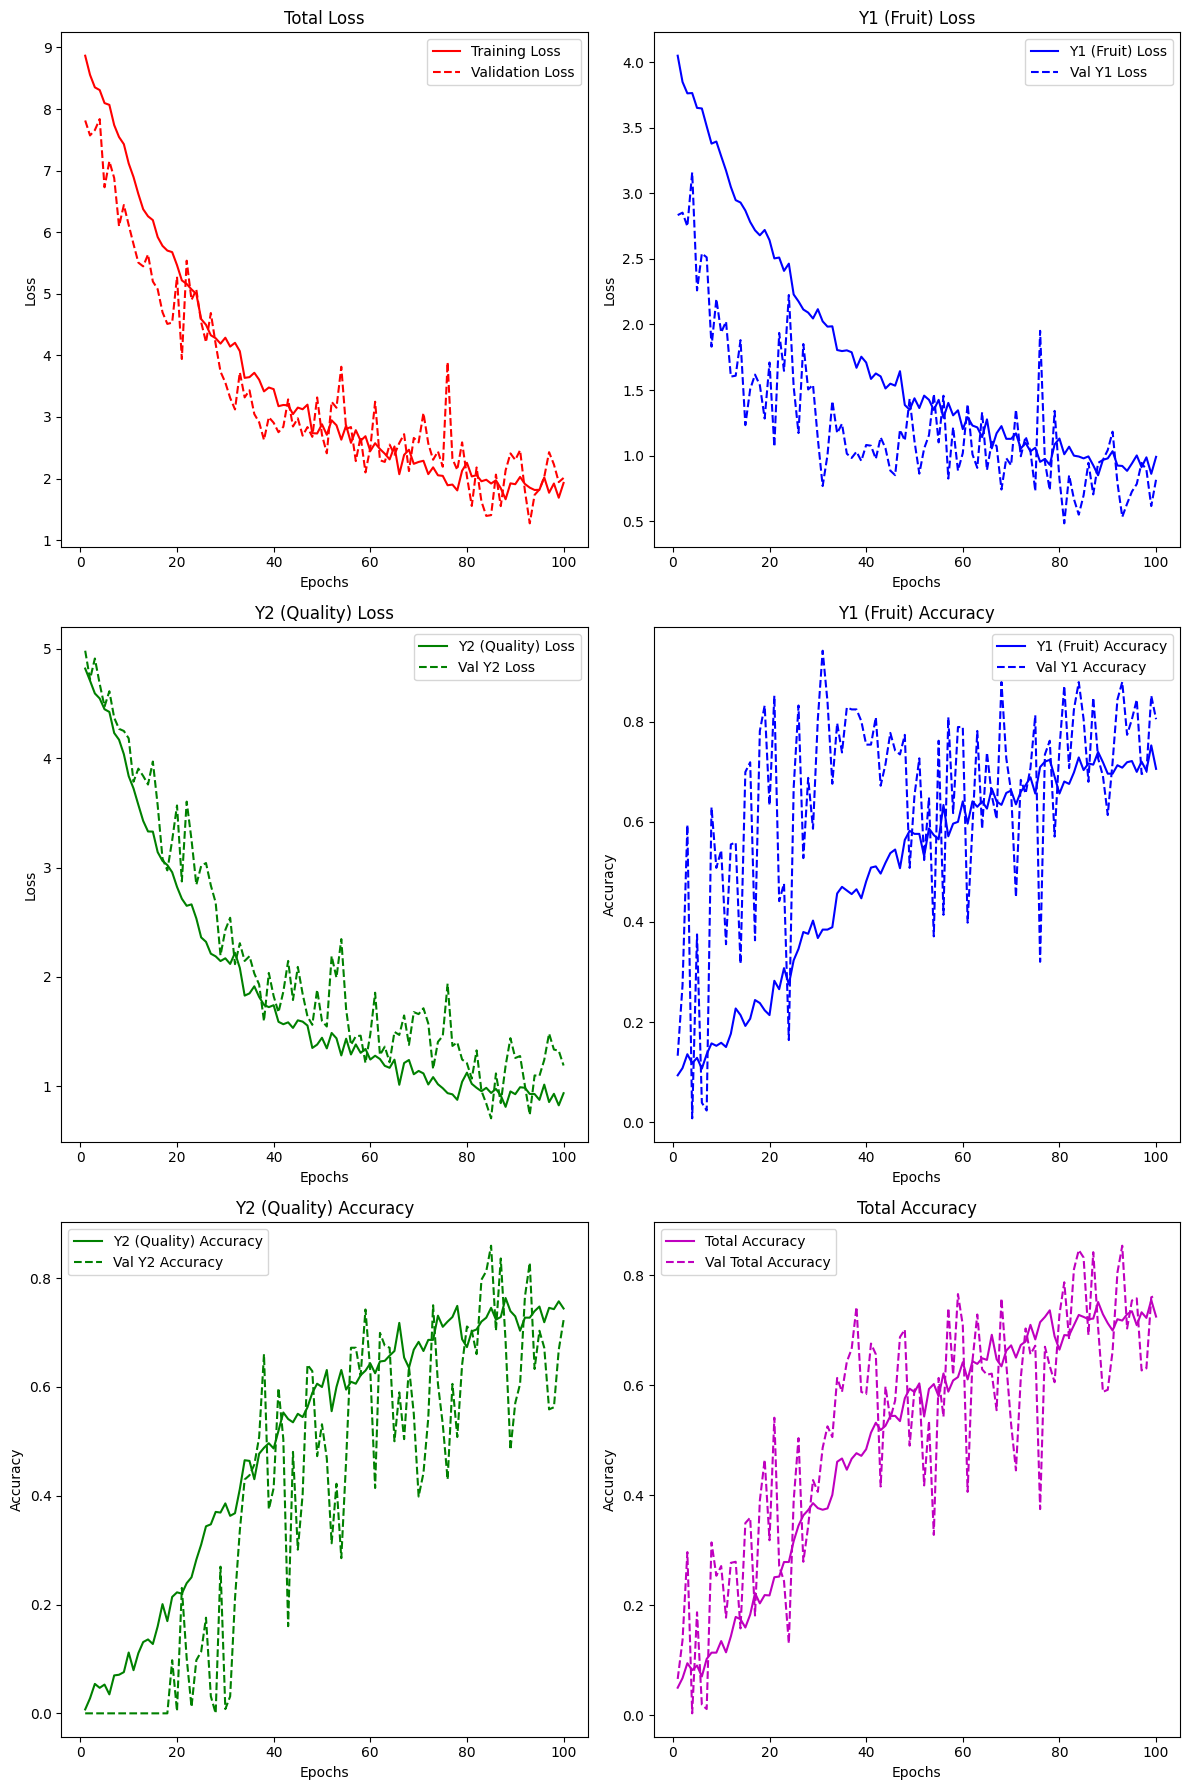

In [ ]:
if(not( os.path.exists('keras/model-CNN-AUG.keras') )):
    plot_training_history(history)

#### Salvataggio in memoria

In [ ]:
model.save("keras/model-CNN-AUG.keras")

In [ ]:
model = load_model("keras/model-CNN-AUG.keras")

#### Valutazione metriche di classificazione

In [ ]:
y1_pred, y2_pred = model.predict(x_test)

y1_pred_classes = np.argmax(y1_pred, axis=1)
y2_pred_classes = np.argmax(y2_pred, axis=1)

y1_test_classes = np.argmax(y1_test, axis=1)
y2_test_classes = np.argmax(y2_test, axis=1)

440/440 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step


In [ ]:
# Valutazione del modello sul test set
loss, loss_y1, loss_y2, acc_y1, acc_y2 = model.evaluate(x_test, {"y1": y1_test, "y2": y2_test}, verbose=0)

print(f"Loss Totale: {loss:.4f}")
print(f"Loss Y1 (Fruit): {loss_y1:.4f}")
print(f"Loss Y2 (Quality): {loss_y2:.4f}")
print(f"Accuracy Y1 (Fruit): {acc_y1:.4f}")
print(f"Accuracy Y2 (Quality): {acc_y2:.4f}")

Loss Totale: 1.4089
Loss Y1 (Fruit): 0.6969
Loss Y2 (Quality): 0.7130
Accuracy Y1 (Fruit): 0.8044
Accuracy Y2 (Quality): 0.8148


In [ ]:
#F1-score
y_pred_m1 = (y1_pred > 0.5).astype(int) 

f1 = f1_score(y1_test, y_pred_m1, average="weighted")
print(f'F1 Score: {f1}')

F1 Score: 0.779908611977167


In [ ]:
#F1-score
y_pred_m2 = (y2_pred > 0.5).astype(int) 

f2 = f1_score(y2_test, y_pred_m2, average="weighted")
print(f'F1 Score: {f2}')

F1 Score: 0.7817022323710353


In [ ]:
print("Classification Report per Y1 (Frutto):")
print(classification_report(y1_test_classes, y1_pred_classes))

print("Classification Report per Y2 (Qualità):")
print(classification_report(y2_test_classes, y2_pred_classes))

📌 Classification Report per Y1 (Frutto):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1510
           1       0.75      0.92      0.83        98
           2       0.94      0.74      0.83       183
           3       0.65      0.86      0.74       286
           4       0.85      0.76      0.80        90
           5       0.84      0.71      0.77        92
           6       0.83      0.89      0.86        28
           7       0.61      0.69      0.65        98
           8       0.91      0.91      0.91       196
           9       0.63      0.68      0.66        98
          10       1.00      0.93      0.97        30
          11       0.90      0.89      0.89       140
          12       0.85      0.91      0.88       686
          13       0.78      0.63      0.70        90
          14       0.76      1.00      0.86        98
          15       0.98      0.88      0.92        98
          16       0.75      0.94      0

#### Visualizzazione errori su test interno

Si visualizzano su quali immagini la CNN fa' una predizione errata:

In [ ]:
# Trova gli indici degli errori
wrong_indices = np.where(y2_pred_classes != y2_test_classes)[0]

# Seleziona fino a 16 immagini casuali dagli errori
num_samples = min(16, len(wrong_indices))  # Evita errori se ci sono meno di 16 errori
random_wrong_indices = np.random.choice(wrong_indices, num_samples, replace=False)

# Mostra le immagini errate
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        idx = random_wrong_indices[i]
        
        #  Controllo formato e normalizzazione
        img = np.clip(x_test[idx], 0, 1) # Assicura che plt.imshow() funzioni bene

        ax.imshow(img)
        ax.set_title(f"True: {y2_test_classes[idx]}, Pred: {y2_pred_classes[idx]}")
    ax.axis("off")

plt.show()

440/440 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step


#### Valutazione Test esterno

In [ ]:
# Percorso della cartella con le immagini
cartella_immagini = "Ext_Test"

In [ ]:
# Funzione per ridimensionare l'immagine mantenendo i canali RGB iniziali
def resize_image_keep_aspect_ratio(img, target_size=(100, 100)):
    h, w = img.shape[:2]
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Crea un'immagine di sfondo bianca 100x100
    output = np.ones((target_size[1], target_size[0], 3), dtype=np.uint8) * 255
   
    # Calcola il punto di inserimento per centrare l'immagine
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    output[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    # Converti da BGR a RGB
    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    return output_rgb

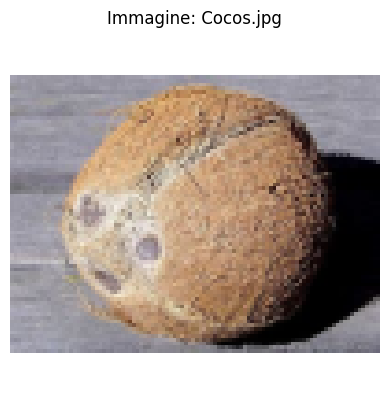

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Cocos.jpg, Predizione: Peach - Peach Flat


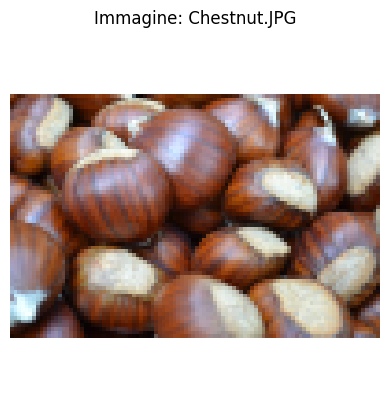

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Chestnut.JPG, Predizione: Apple - Apple Red Yellow


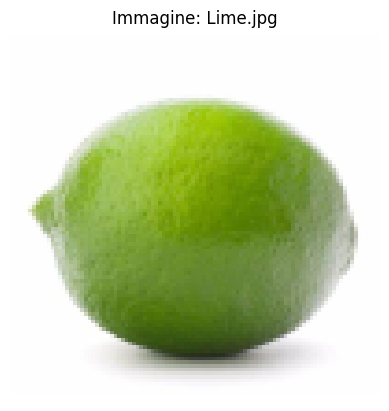

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Immagine: Lime.jpg, Predizione: Grape - Grape White


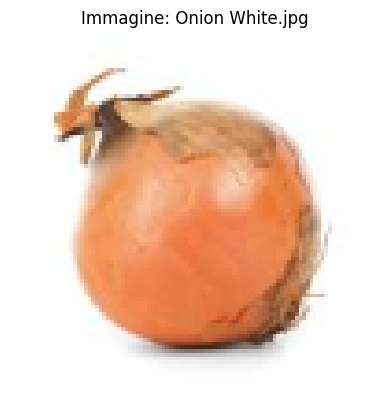

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Immagine: Onion White.jpg, Predizione: Physalis - Grapefruit Pink


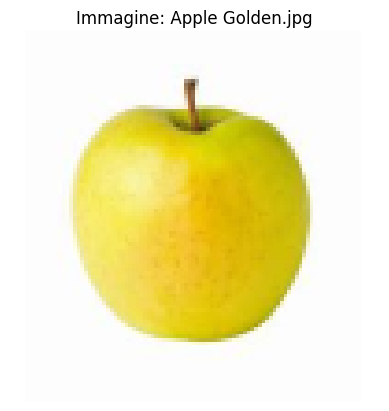

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Apple Golden.jpg, Predizione: Maracuja - Maracuja Undefined


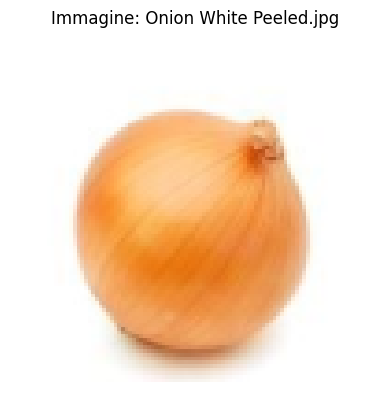

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Onion White Peeled.jpg, Predizione: Physalis - Physalis Undefined


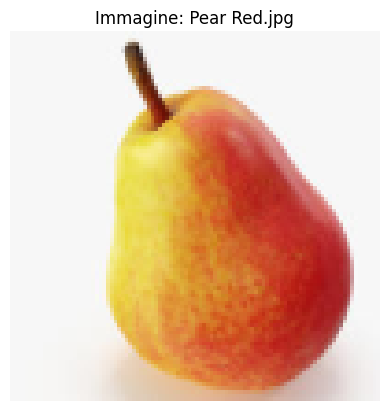

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Pear Red.jpg, Predizione: Cherry - Pear Red


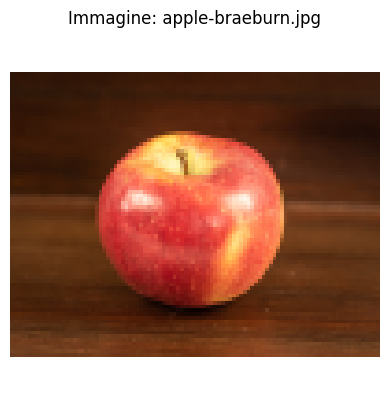

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: apple-braeburn.jpg, Predizione: Apple - Pepper Orange


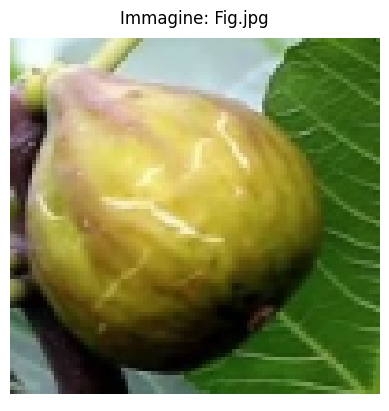

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Fig.jpg, Predizione: Apple - Apple Red Yellow


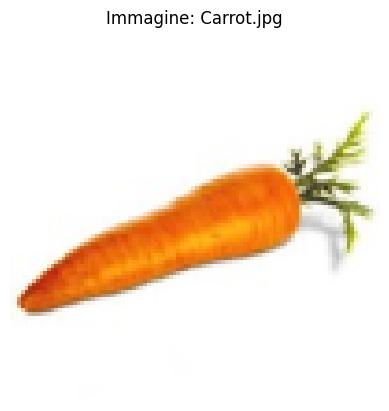

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Immagine: Carrot.jpg, Predizione: Pepper - Pepper Yellow


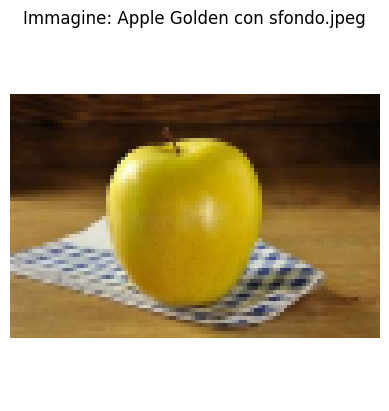

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Apple Golden con sfondo.jpeg, Predizione: Apple - Apple Red Yellow


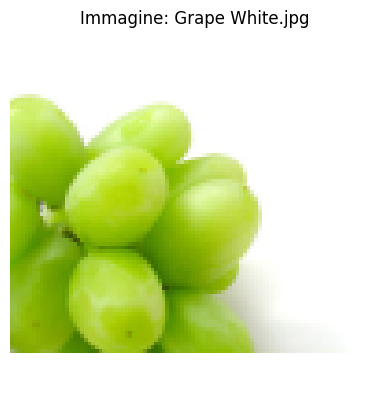

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Grape White.jpg, Predizione: Maracuja - Maracuja Undefined


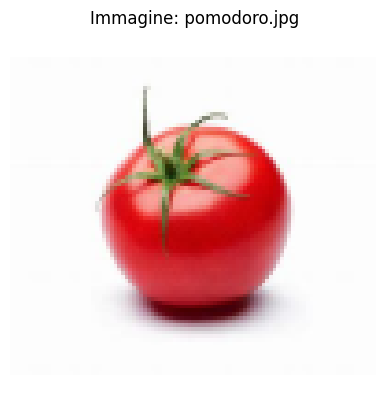

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Immagine: pomodoro.jpg, Predizione: Pear - Pear Red


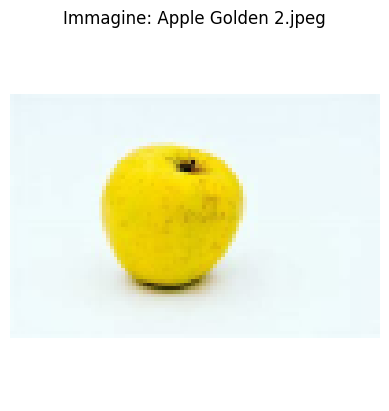

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Apple Golden 2.jpeg, Predizione: Corn - Corn Undefined


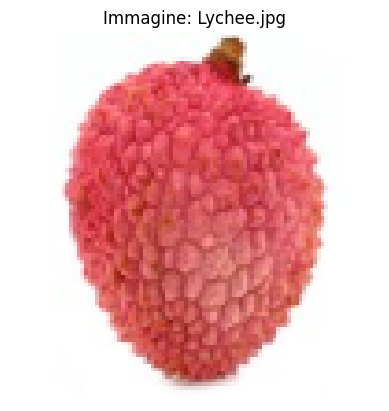

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Immagine: Lychee.jpg, Predizione: Redcurrant - Cherry Rainier


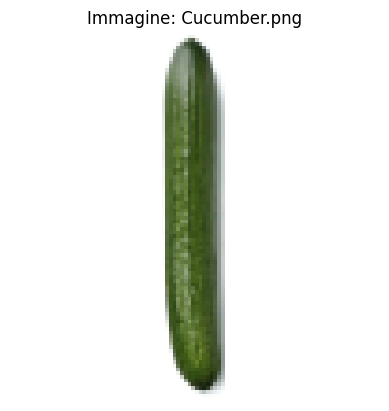

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Cucumber.png, Predizione: Corn - Corn Husk


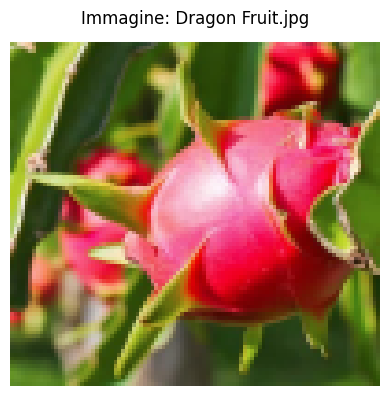

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Dragon Fruit.jpg, Predizione: Apple - Apple Red Yellow


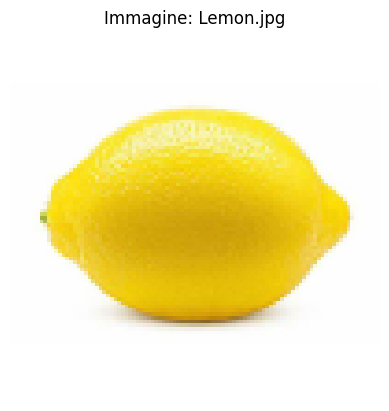

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Lemon.jpg, Predizione: Maracuja - Maracuja Undefined


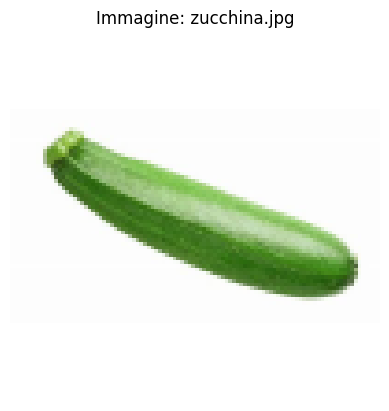

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Immagine: zucchina.jpg, Predizione: Corn - Zucchini Undefined


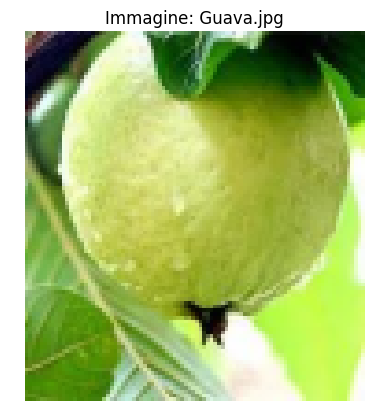

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: Guava.jpg, Predizione: Apple - Apple Golden


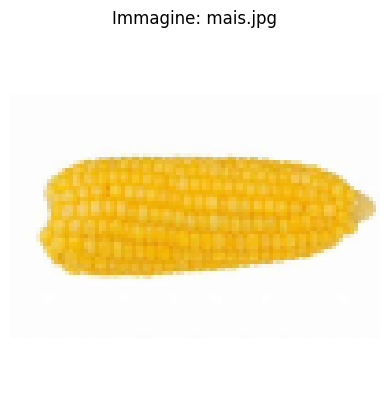

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Immagine: mais.jpg, Predizione: Corn - Corn Undefined


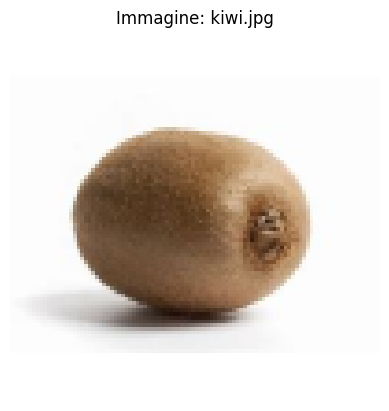

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Immagine: kiwi.jpg, Predizione: Potato - Potato Sweet


In [ ]:
# Itera su tutte le immagini nella cartella
for nome_file in os.listdir(cartella_immagini):
    percorso_file = os.path.join(cartella_immagini, nome_file)

    # Controlla che sia un file immagine
    if not (nome_file.lower().endswith((".jpg", ".png", ".jpeg"))):
        continue

    # Carica l'immagine
    img = cv2.imread(percorso_file)
    if img is None:
        print(f"Errore nel caricamento di {nome_file}")
        continue

    img_resized = resize_image_keep_aspect_ratio(img)

    # Mostra l'immagine
    plt.imshow(img_resized / 255)  # Normalizzazione per la visualizzazione
    plt.title(f"Immagine: {nome_file}")
    plt.axis("off")
    plt.show()

    # Converti in array numpy e normalizza
    img_array = np.expand_dims(img_resized, axis=0).astype("float32") / 255.0  # Normalizzazione 0-1

    # Predizione con il modello custom
    prediction = model.predict(img_array)

    # Se il modello ha due output (frutta e qualità)
    predicted_fruit_idx = np.argmax(prediction[0])  # Output per la categoria frutta
    predicted_quality_idx = np.argmax(prediction[1])  # Output per la qualità

    # Recupera i nomi dai dizionari/liste delle etichette
    predicted_fruit = labels_1_array[predicted_fruit_idx]
    predicted_quality = labels_2_array[predicted_quality_idx]

    # Stampa il risultato
    print(f"Immagine: {nome_file}, Predizione: {predicted_fruit} - {predicted_quality}")

### Modello 1: Siamese netework con tripletts loss

#### Motivazioni scelta del modello 

Si sceglie di realizzare una erte siamese con triplett loss perchè si pensa che il nostro problema di classificazione possa essere in qualche modo riconducilbile all'analisi delle feature facciali (che sarebbe il caso d'uso principale di questo tipo di rete).

In [42]:
from sklearn.datasets import fetch_lfw_people

# Scarica il dataset (resize=0.4 rende le immagini più leggere)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
lfw_images = lfw_people.images  # Immagini  # Array di immagini

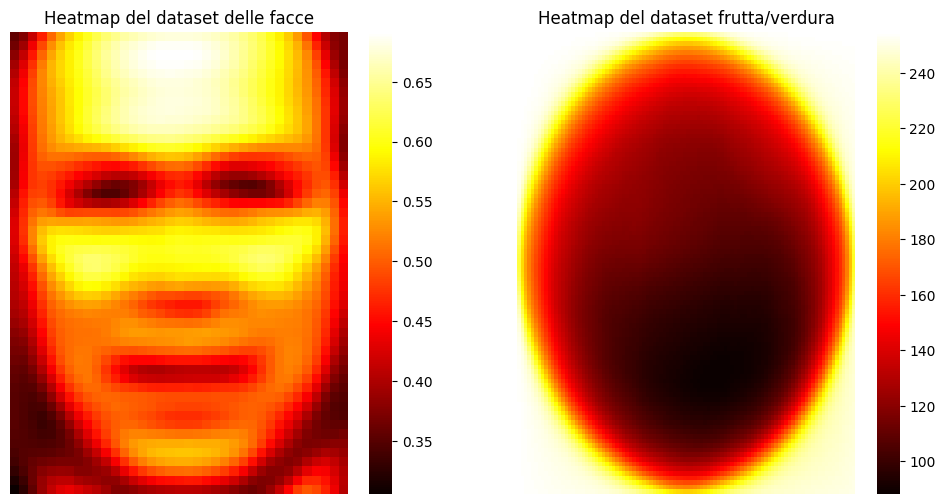

In [ ]:
# Calcola l'immagine media per entrambi i dataset
mean_face = np.mean(lfw_images, axis=0)  # Media facce
mean_custom = np.mean(x_train, axis=(0, -1))  # Media dataset personale

# Plotta le due heatmap affiancate
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(mean_face, cmap="hot", xticklabels=False, yticklabels=False, ax=axes[0])
axes[0].set_title("Heatmap del dataset delle facce")

sns.heatmap(mean_custom, cmap="hot", xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_title("Heatmap del dataset frutta/verdura")

plt.show()

Andando a recuperare un dataset di facce è possbile confermare delle heatmap mostrate un paio di similitudini:
- In entrambi i dataset si può ricostruire una forma "standard" e regolare che ogni elemento del dataset può assunmere. (dove per le facce è appunto la forma di una mashera facciale e per i frutti/verdura è un cerchio dato che molti frutti sono di questa dimensione) 
- In entrambi i dataset sono preseni grosse aree ad alta varianza che aiutano a distinguere l'immagine (nel dataset facciale sono principalmente bocca ed occhi; mentre nel dataset dei frutti corrisponde con la zona inferiore del frutto/verdura)

Essendo quindi i due problemi facilmente riconducibili l'uno con l'altro si pensa che l'utilizzo di questa rete possa essere uno strumento efficace per l'apprendimento di questo problema di classificazione. 

#### Definizione steps per modello siamese

è possibile creare una rete siamese con due output che gestisca sia la label1 che la label2. La struttura della rete può essere progettata in questo modo:

1. **Un backbone condiviso**: una CNN equivalente al modello-0 per estrarre le feature dalle immagini.
    
2. **Doppio ramo di embedding**: una testa di rete per produrre embedding separati per la label1 e la label2.
    
3. **Loss triplet separata per ciascun output**: una per la label1 e una per la label2.
    
4. **Input multiplo**: la rete riceverà cinque immagini come input.
    

La funzione di loss potrebbe essere la combinazione di due triplet loss, una per ciascun output:
$$\mathcal{L} = \mathcal{L}_{\text{triplet1}} + \mathcal{L}_{\text{triplet2}}$$

Dove:

- $\mathcal{L}_{\text{triplet1}}$ usa anchor, positivo e negativo per label1.
- $\mathcal{L}_{\text{triplet2}}$ usa anchor, positivo e negativo per label2.


In [44]:
batch_size = 32

#### Preparazione dei dati per essere processati con triplett loss

nota che in questa funzione si fa anche normalizzazione dei dati:

In [45]:
def triplet_generator(x, y1, y2, batch_size=32):
    while True:
        anchor_batch, pos1_batch, neg1_batch, pos2_batch, neg2_batch, labels1, labels2 = [], [], [], [], [],  [], []

        for _ in range(batch_size):
            idx_anchor = np.random.randint(0, len(x))
            anchor = x[idx_anchor] / 255

            label1_anchor = y1[idx_anchor]
            label2_anchor = y2[idx_anchor]
            labels1.append(label1_anchor)
            labels2.append(label2_anchor)

            # Trova un positivo e un negativo per label1
            pos1_idx = np.random.choice(np.where(np.argmax(y1, axis=1) == np.argmax(label1_anchor))[0])
            neg1_idx = np.random.choice(np.where(np.argmax(y1, axis=1) != np.argmax(label1_anchor))[0])

            pos1 = x[pos1_idx] / 255
            neg1 = x[neg1_idx] / 255

            # Trova un positivo e un negativo per label2
            pos2_idx = np.random.choice(np.where(np.argmax(y2, axis=1) == np.argmax(label2_anchor))[0])
            neg2_idx = np.random.choice(np.where(np.argmax(y2, axis=1) != np.argmax(label2_anchor))[0])

            pos2 = x[pos2_idx] / 255
            neg2 = x[neg2_idx] / 255

            anchor_batch.append(anchor)
            pos1_batch.append(pos1)
            neg1_batch.append(neg1)
            pos2_batch.append(pos2)
            neg2_batch.append(neg2)

        yield ((np.array(anchor_batch), np.array(pos1_batch), np.array(neg1_batch),
                np.array(pos2_batch), np.array(neg2_batch)),  # 5 immagini separate
               (np.array(labels1), np.array(labels2))) 

Anchor shape: (32, 100, 100, 3)
Positives shape: (32, 100, 100, 3)
Negatives shape: (32, 100, 100, 3)
labels: Apple - Apple Golden


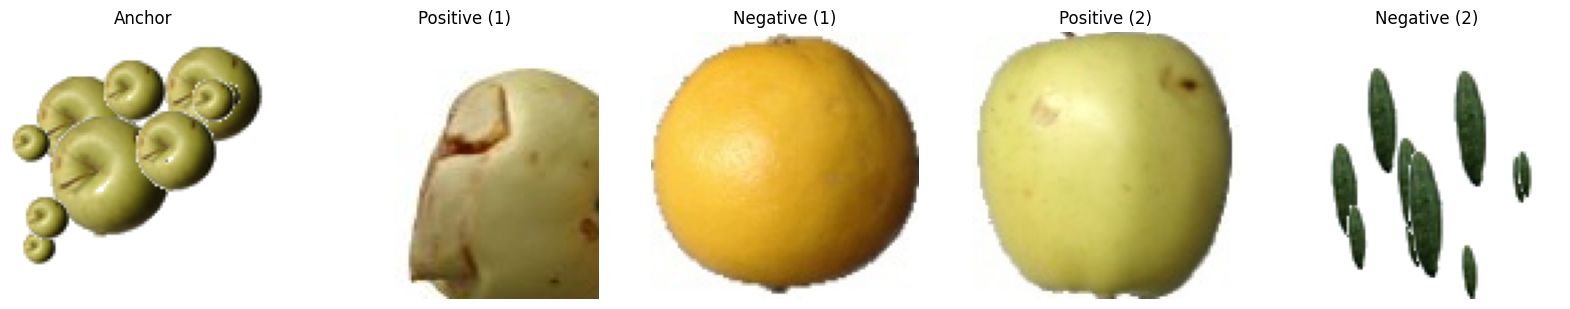

In [ ]:
# Creazione del dataset TensorFlow
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(x_train, y1_train, y2_train, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),  # Anchor
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),  # Positivo label1
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),  # Negativo label1
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),  # Positivo label2
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32)), # Negativo label2
        (tf.TensorSpec(shape=((batch_size, 70)), dtype=tf.float32),  # Output 1
         tf.TensorSpec(shape=((batch_size, 121)), dtype=tf.float32))  # Output 2
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(x_val, y1_val, y2_val, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32)),
        (tf.TensorSpec(shape=((batch_size, 70)), dtype=tf.float32),
         tf.TensorSpec(shape=((batch_size, 121)), dtype=tf.float32))
    )
)


for batch in train_dataset.take(1):
    (anchors, positives1, negatives1, positive2, negative2),(label1,label2) = batch
    print("Anchor shape:", anchors.shape)
    print("Positives shape:", positives1.shape)
    print("Negatives shape:", negatives1.shape)


# Fetch one batch and display a sample
for batch in train_dataset.take(1):
    (anchors, positives1, negatives1, positive2, negative2),(label1,label2) = batch
     
    # Convert one-hot encoded labels back to integer class values
    label1_int = np.argmax(label1, axis=1)
    label2_int = np.argmax(label2, axis=1)

    print(f"labels: {label_names_y1[label1_int[0]]} - {label_names_y2[label2_int[0]]}")
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow((anchors[0].numpy() * 255).astype("uint8"))
    axes[0].set_title("Anchor")
    axes[1].imshow((positives1[0].numpy() * 255).astype("uint8"))
    axes[1].set_title("Positive (1)")
    axes[2].imshow((negatives1[0].numpy() * 255).astype("uint8"))
    axes[2].set_title("Negative (1)")
    axes[3].imshow((positive2[0].numpy() * 255).astype("uint8"))
    axes[3].set_title("Positive (2)")
    axes[4].imshow((negative2[0].numpy() * 255).astype("uint8"))
    axes[4].set_title("Negative (2)")
    for ax in axes:
        ax.axis("off")
    plt.show()
    break


#### Implementazione del modello:

Backbone (rete embedded che processa le feature delle immagini in input):

In [ ]:
def build_custom_encoder():
    """
    Costruisce un encoder CNN per l'estrazione di feature.
    """
    inputs = Input(shape=(100, 100, 3))
    
    x = Conv2D(64, (9, 9), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1), output_shape=(1024,))(x)
    
    return Model(inputs, x, name="custom_encoder")

Modello siamese (modello wrapper che permette di prendere in input 5 immagini alla volta):

In [ ]:
def build_dual_output_siamese_model(encoder, output_shape=(3, 128)):
    """
    Costruisce una rete siamese con due output separati.
    """
    anchor_input = Input(shape=(100, 100, 3), name="anchor")
    positive1_input = Input(shape=(100, 100, 3), name="positive1")
    negative1_input = Input(shape=(100, 100, 3), name="negative1")
    positive2_input = Input(shape=(100, 100, 3), name="positive2")
    negative2_input = Input(shape=(100, 100, 3), name="negative2")
    
    # Estrazione feature con encoder condiviso
    anchor_emb = encoder(anchor_input)
    positive1_emb = encoder(positive1_input)
    negative1_emb = encoder(negative1_input)
    positive2_emb = encoder(positive2_input)
    negative2_emb = encoder(negative2_input)
    
    # Raggruppamento embedding per label1 e label2
    embeddings_label1 = Lambda(lambda x: tf.stack(x, axis=1), output_shape=output_shape, name="triplett_label1")([anchor_emb, positive1_emb, negative1_emb])
    embeddings_label2 = Lambda(lambda x: tf.stack(x, axis=1), output_shape=output_shape, name="triplett_label2")([anchor_emb, positive2_emb, negative2_emb])
    return Model(
        inputs=[anchor_input, positive1_input, negative1_input, positive2_input, negative2_input],
        outputs=[embeddings_label1, embeddings_label2],
        name="dual_output_siamese_network"
    )

Definizione triplett loss custom che fa' la somma delle 2 triplett loss di label1 e label2:

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

def triplet_loss(margin=0.1):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)

    return loss

#### Train della rete:

In [51]:
# Costruisci il modello
batch_size = 32

In [52]:
# Costruisci l'encoder
encoder = build_custom_encoder()
encoder.summary()

Model: "custom_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 92, 92, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1024)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,536 (1.59 MB)

 Trainable params: 417,536 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Costruisci il modello siamese con doppio output
siamese_model = build_dual_output_siamese_model(encoder)
siamese_model.summary()

Model: "dual_output_siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 100, 100,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive1           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative1           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive2           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative2           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_encoder      │ (None, 1024)      │    417,536 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive1[0][0],  │
│                     │                   │            │ negative1[0][0],  │
│                     │                   │            │ positive2[0][0],  │
│                     │                   │            │ negative2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triplett_label1     │ (None, 3, 128)    │          0 │ custom_encoder[0… │
│ (Lambda)            │                   │            │ custom_encoder[1… │
│                     │                   │            │ custom_encoder[2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triplett_label2     │ (None, 3, 128)    │          0 │ custom_encoder[0… │
│ (Lambda)            │                   │            │ custom_encoder[3… │
│                     │                   │            │ custom_encoder[4… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 417,536 (1.59 MB)

 Trainable params: 417,536 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Definisci due loss separate per label1 e label2
loss1 = triplet_loss(margin=0.1)
loss2 = triplet_loss(margin=0.1)

# Compila il modello con la somma delle due loss
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                      loss={'triplett_label1': loss1, 'triplett_label2': loss2})  # Associa la loss ai due output


dataset_size = len(x_train)  # Numero totale di campioni
epochs_number = 30

steps_per_epoch = int(1.5* dataset_size / batch_size / epochs_number)
steps_per_val = int(len(x_val) / batch_size / epochs_number)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Steps per val: {steps_per_val}")

Steps per epoch: 88
Steps per val: 24


Nota che per velocizzare il train ed evitare di overfitatre sui dati di train, si sceglie di impostare un valore di steps per epochs uguale a: $$ \frac{ 150\% \text{ dell'intero dataset}} {\text{numero di epoche}} $$In questo si ha che per ogni singola epoca si visiterà in totale solo una frazione del dataset; invece che avere che per ogni singola epoca far visitare tutto il set. Avendo quindi un totale di 20 epoche vuol dire che, su tutte le 20 epoche si visiteranno in totatle un quantitivo di immagini totali pari alla lunghezza di tutto tutto il dataset per 1.5. Questo perchè ogni batch viene estratto casualmente, quindi se avessimo visto solo la lunghezza di tutto il dataset si correva il rischio di non visualizzare tutte le immagini. Aggiungendo questa moltiplicazione per 1.5 questo rischio non viene azzerato ma viene alleviato di molto.

Questo porta ad avere che la loss potrebbe avere comportamenti fluttuanti (scendi / sali) quando si scoprono per la prima volta sample che non sono mai stati esplorati in epoche precedenti, ma avendo un totale di 20 epoche è altamente probabile che entro la fine del train tutti i dati siano stati visitati più di una volta. 
In questo modo si riescono a miglorare di moltissimo i tempi di train. 

In [ ]:
# Check if history file exists
if os.path.exists("siamese_history.npz"):
    encoder = load_model("encoder.keras")
    siamese_model = load_model("siamese_model.keras")
    data = np.load("hsiamese_history.npz")
    history = {key: data[key] for key in data.files}
    print("History loaded successfully.")
else:
    history = siamese_model.fit(
        train_dataset,
        epochs=epochs_number,
        validation_data=val_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_val
    )
    encoder.save("encoder.keras")
    siamese_model.save("siamese_model.keras")
    np.savez("siamese_history.npz", **history.history)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - loss: 0.2619 - triplett_label1_loss: 0.1317 - triplett_label2_loss: 0.1303 - val_loss: 0.1453 - val_triplett_label1_loss: 0.0869 - val_triplett_label2_loss: 0.0584
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 0.1817 - triplett_label1_loss: 0.1049 - triplett_label2_loss: 0.0769 - val_loss: 0.1442 - val_triplett_label1_loss: 0.0929 - val_triplett_label2_loss: 0.0513
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.1698 - triplett_label1_loss: 0.0903 - triplett_label2_loss: 0.0795 - val_loss: 0.1548 - val_triplett_label1_loss: 0.1024 - val_triplett_label2_loss: 0.0524
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - loss: 0.1653 - triplett_label1_loss: 0.0942 - triplett_label2_loss: 0.0711 - val_loss: 0.1217 - val_triplett_label1_loss: 0.0770 - val_triplett_label2_loss: 0.0447
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 0.1528 - triplett_label1_loss: 0.0907 - triplett_label2_loss: 0.0621 - va

In [ ]:
def plot_dual_siamese_history(history):
    """
    Plots the training history of the dual-output Siamese model.
    """
    fig = plt.figure(figsize=(12, 8))  # Overall figure size

    # General Loss (first row, spans 2 columns)
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)  # Full-width first row
    ax1.plot(history["loss"], label="Train Loss", color="blue")
    ax1.plot(history["val_loss"], label="Val Loss", color="orange")
    ax1.set_title("General Loss (Loss1+Loss2)")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    # Loss for Label1 (second row, left)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.plot(history["triplett_label1_loss"], label="Train Loss Label1", color="blue")
    ax2.plot(history["val_triplett_label1_loss"], label="Val Loss Label1", color="orange")
    ax2.set_title("Loss for Label1")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    # Loss for Label2 (second row, right)
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.plot(history["triplett_label2_loss"], label="Train Loss Label2", color="blue")
    ax3.plot(history["val_triplett_label2_loss"], label="Val Loss Label2", color="orange")
    ax3.set_title("Loss for Label2")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Loss")
    ax3.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

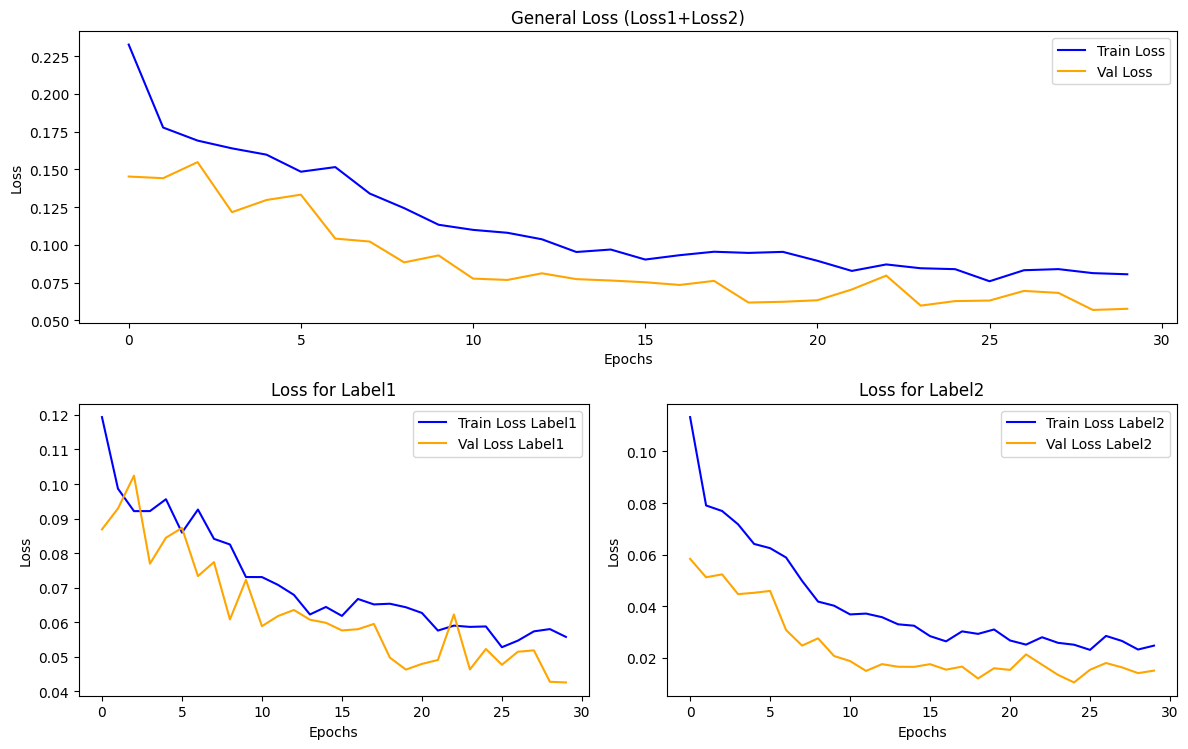

In [ ]:
plot_dual_siamese_history(history.history)

Overall l'andamento della loss non è neacnhe così tanto malvagio. Seppure siano presenti evidenti flunctuation è comunque possibile notare le tendenze negative dei tutte le curve. Una possbile soluzione per migliorara l'andamento di questa curva sarebbe cambiare il learning rate ma, come potremo nontare in seguito, anche cambiando il learning rate non si otterranno grandissimi risultati. 

#### Predizioni sul test set

Una volta che il modello è addestrato, se ne estraggono le feature e si prova a trainare 2 SVM (uno per output). In questo modo si fa' model compression (utilizzando il metodo della **knowledge distillation**) e si riesce per ogni immagine di input ad assegnare una vera e propria label, in modo da poter avere 2 modelli che presi in input le feature estratte e la label riesca a predirre a sua volta una label di predizione.  

Il processo sarebbe il seguente:
1. **Estrazione delle feature**: Usa la rete siamese per generare gli embedding delle immagini nel set di training.
2. **Allenamento degli SVM**: Addestra due SVM separati (uno per label1 e uno per label2) usando gli embedding come input e le etichette corrispondenti come target.
3. **Valutazione**: Calcola l'accuracy degli SVM sul set di validazione per determinare la qualità delle feature.
4. **Predizione**: Una volta addestrati, puoi passare una nuova immagine attraverso la rete per ottenere l'embedding e poi classificarla con gli SVM.

Questo approccio ti permette di avere una metrica di accuratezza ben definita e di verificare se gli embedding appresi sono discriminativi.

##### 1. Estrazione delle feature:

In [ ]:
# Estrai le feature passando le immagini nel modello siamese
feature_extractor = encoder

train_features = feature_extractor.predict(x_train)
val_features = feature_extractor.predict(x_val)
test_features = feature_extractor.predict(x_test)

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 140s 79ms/step
870/870 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step
440/440 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step


##### 2. Allenamento degli SVM

In [60]:
# Crea pipeline con normalizzazione + SVM
svm1 = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', probability=True))])
svm2 = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', probability=True))])

# Converte one-hot in etichette scalari
y1_train = np.argmax(y1_train, axis=1)  
y2_train = np.argmax(y2_train, axis=1)

# Allena gli SVM
svm1.fit(train_features, y1_train)
svm2.fit(train_features, y2_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(kernel='linear', probability=True))])

##### 3. Predizione sui dati di test

In [ ]:
# Predici le classi sulle feature di validazione
y1_pred = svm1.predict(val_features)
y2_pred = svm2.predict(val_features)

# converti da onehot a normali
y1_val = np.argmax(y1_val, axis=1)
y2_val = np.argmax(y2_val, axis=1)

# Calcola accuracy
acc1 = accuracy_score(y1_val, y1_pred)
acc2 = accuracy_score(y2_val, y2_pred)

print(f"Accuracy per Label 1: {acc1 * 100:.2f}%")
print(f"Accuracy per Label 2: {acc2 * 100:.2f}%")

f1_1 = f1_score(y1_val, y1_pred, average='macro')
f1_2 = f1_score(y2_val, y2_pred, average='macro')

print(f"F1-score per Label 1: {f1_1*100:.2f}%")
print(f"F1-score per Label 2: {f1_2*100:.2f}%")

Accuracy per Label 1: 85.37%
Accuracy per Label 2: 86.48%
F1-score per Label 1: 85.62%
F1-score per Label 2: 85.68%


#### Valutazione Test esterno

In [62]:
def classify_image(image_path, model, svm1, svm2):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Preprocessa l'immagine
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Aggiunge batch dimension

    # Estrai le feature con il modello siamese
    features = model.predict(img_array)
    # Classifica con gli SVM
    label1_pred = svm1.predict(features)[0]
    label2_pred = svm2.predict(features)[0]

    return label1_pred, label2_pred

In [ ]:
# Directory containing the images
ext_test_dir = "Ext_Test"

# Iterate over all images in the directory
for image_file in os.listdir(ext_test_dir):
    image_path = os.path.join(ext_test_dir, image_file)
    print("----------------------------------------------------------")
    label1, label2 = classify_image(image_path, feature_extractor, svm1, svm2)
    print(f"Image: {image_file}")
    print(f"Predicted Label 1: {labels_1_array[label1]}, Predicted Label 2: {labels_2_array[label2]}")

----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Image: Apple Golden 2.jpeg
Predicted Label 1: Banana, Predicted Label 2: Banana Lady Finger
----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image: Apple Golden con sfondo.jpeg
Predicted Label 1: Pear, Predicted Label 2: Onion Red
----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: Apple Golden.jpg
Predicted Label 1: Apple, Predicted Label 2: Apple Undefined
----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: apple-braeburn.jpg
Predicted Label 1: Walnut, Predicted Label 2: Potato Red
----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: Carrot.jpg
Predicted Label 1: Cucumber, Predicted Label 2: Cucumber Ripe
----------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Modello 2: ResNet101

#### Reload dateset

In [ ]:
x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test = reaload_from_scratch()

#### Normalizzazione dati:

In [ ]:
x_train_preprocessed = tf.keras.applications.resnet.preprocess_input(x_train)
x_val_preprocessed = tf.keras.applications.resnet.preprocess_input(x_val)
x_test_preprocessed = tf.keras.applications.resnet.preprocess_input(x_test)

#### Calcolo steps per epochs

In [ ]:
dataset_size = len(x_train)  # Numero totale di campioni
epochs_number = 100
batch_size = 32

steps_per_epoch = int(1.5* dataset_size / batch_size / epochs_number)
steps_per_val = int(len(x_val) / batch_size / epochs_number)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Steps per val: {steps_per_val}")

Steps per epoch: 26
Steps per val: 7


#### Implementazione ResNet101

In [ ]:
input_shape = x_train.shape[1:]
print(input_shape)
num_classes_1 = y1_train.shape[1]
print(num_classes_1)
num_classes_2 = y2_train.shape[1]
print(num_classes_2)

(100, 100, 3)
70
121


In [ ]:
# Carica ResNet101 senza la testa di classificazione
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
# Sblocca la ResNet101
base_model.trainable = False

# Appiattimento dell'output della ResNet101
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(256, activation="relu")(x)  # Riduci la dimensionalità
x = Dropout(0.3)(x)  # Evita overfitting
x = Dense(128, activation="relu")(x)  # Ulteriore compressione

# Ramo 1 - Predizione del Frutto
fruit_output = Dense(num_classes_1, activation="softmax", name="y1")(x)

# Ramo 2 - Predizione della Qualità
quality_output = Dense(num_classes_2, activation="softmax", name="y2")(x)

# Modello finale
model = Model(inputs=base_model.input, outputs=[fruit_output, quality_output])

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitora la perdita sulla validation set
    patience=10,         # Numero di epoche senza miglioramenti prima di fermarsi
    min_delta=1e-5,      # Delta minimo per considerare un miglioramento
    mode="min",          # Si ferma quando 'val_loss' smette di diminuire
    restore_best_weights=True  # Ripristina i pesi della migliore epoca
)

In [ ]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 44,404,415 (169.39 MB)

 Trainable params: 582,079 (2.22 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 1,164,160 (4.44 MB)

#### Train del modello

In [ ]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])

# Compilazione del modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #optimizer = "adam",
    loss={
            'y1': 'categorical_crossentropy',
            'y2': 'categorical_crossentropy'
        },
    metrics={
        'y1': 'accuracy',
        'y2': 'accuracy'
    }
)

In [ ]:
if(os.path.exists('modelLastDatasetLearningRate.keras')):
    model = keras.models.load_model("modelLastDatasetLearningRate.keras")
else:
    # Addestramento del modello
    history = model.fit(x_train_preprocessed,
                        {
                            'y1': y1_train,
                            'y2': y2_train
                        },
                        validation_data=(
                            x_val_preprocessed,
                            {
                                'y1': y1_val,
                                'y2': y2_val
                            }
                        ),
                        epochs=epochs_number,  # Numero di batch per epoca
                        batch_size=batch_size,
                        steps_per_epoch = steps_per_epoch,
                        validation_steps=steps_per_val,
                        callbacks=[early_stopping]
                        )


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 10.7638 - y1_accuracy: 0.0234 - y1_loss: 5.0215 - y2_accuracy: 0.0102 - y2_loss: 5.7422 - val_loss: 7.2251 - val_y1_accuracy: 0.5848 - val_y1_loss: 2.7996 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.4255
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 9.0082 - y1_accuracy: 0.0770 - y1_loss: 4.0874 - y2_accuracy: 0.0280 - y2_loss: 4.9209 - val_loss: 6.8256 - val_y1_accuracy: 0.7589 - val_y1_loss: 2.4776 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.3480
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 930ms/step - loss: 8.4763 - y1_accuracy: 0.1607 - y1_loss: 3.7337 - y2_accuracy: 0.0524 - y2_loss: 4.7426 - val_loss: 6.2223 - val_y1_accuracy: 0.7812 - val_y1_loss: 1.9993 - val_y2_accuracy: 0.0000e+00 - val_y2_loss: 4.2230
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 8.1562 - y1_accuracy: 0.1788 - y1_loss: 3.5368 - y2_accuracy: 0.0671 - y2_loss: 4.6194 - val_loss: 5.7123 - val_y1_accuracy: 0.7232 - val_y1_l

C:\Users\fabio\PycharmProjects\AMLProject\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 833ms/step - loss: 0.9986 - y1_accuracy: 0.8814 - y1_loss: 0.4185 - y2_accuracy: 0.8593 - y2_loss: 0.5799 - val_loss: 0.4754 - val_y1_accuracy: 0.9688 - val_y1_loss: 0.1463 - val_y2_accuracy: 0.9062 - val_y2_loss: 0.3291
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 903ms/step - loss: 1.0103 - y1_accuracy: 0.8887 - y1_loss: 0.4243 - y2_accuracy: 0.8442 - y2_loss: 0.5860 - val_loss: 0.3599 - val_y1_accuracy: 0.9911 - val_y1_loss: 0.0909 - val_y2_accuracy: 0.9420 - val_y2_loss: 0.2690
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 908ms/step - loss: 0.9618 - y1_accuracy: 0.8924 - y1_loss: 0.3992 - y2_accuracy: 0.8469 - y2_loss: 0.5626 - val_loss: 0.3176 - val_y1_accuracy: 0.9911 - val_y1_loss: 0.0998 - val_y2_accuracy: 0.9955 - val_y2_loss: 0.2178
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 904ms/step - loss: 0.9221 - y1_accuracy: 0.8933 - y1_loss: 0.3884 - y2_accuracy: 0.8538 - y2_loss: 0.5338 - val_loss: 0.4230 - val_y1_accuracy: 0.9420 - val_y1_loss: 0.1810 -

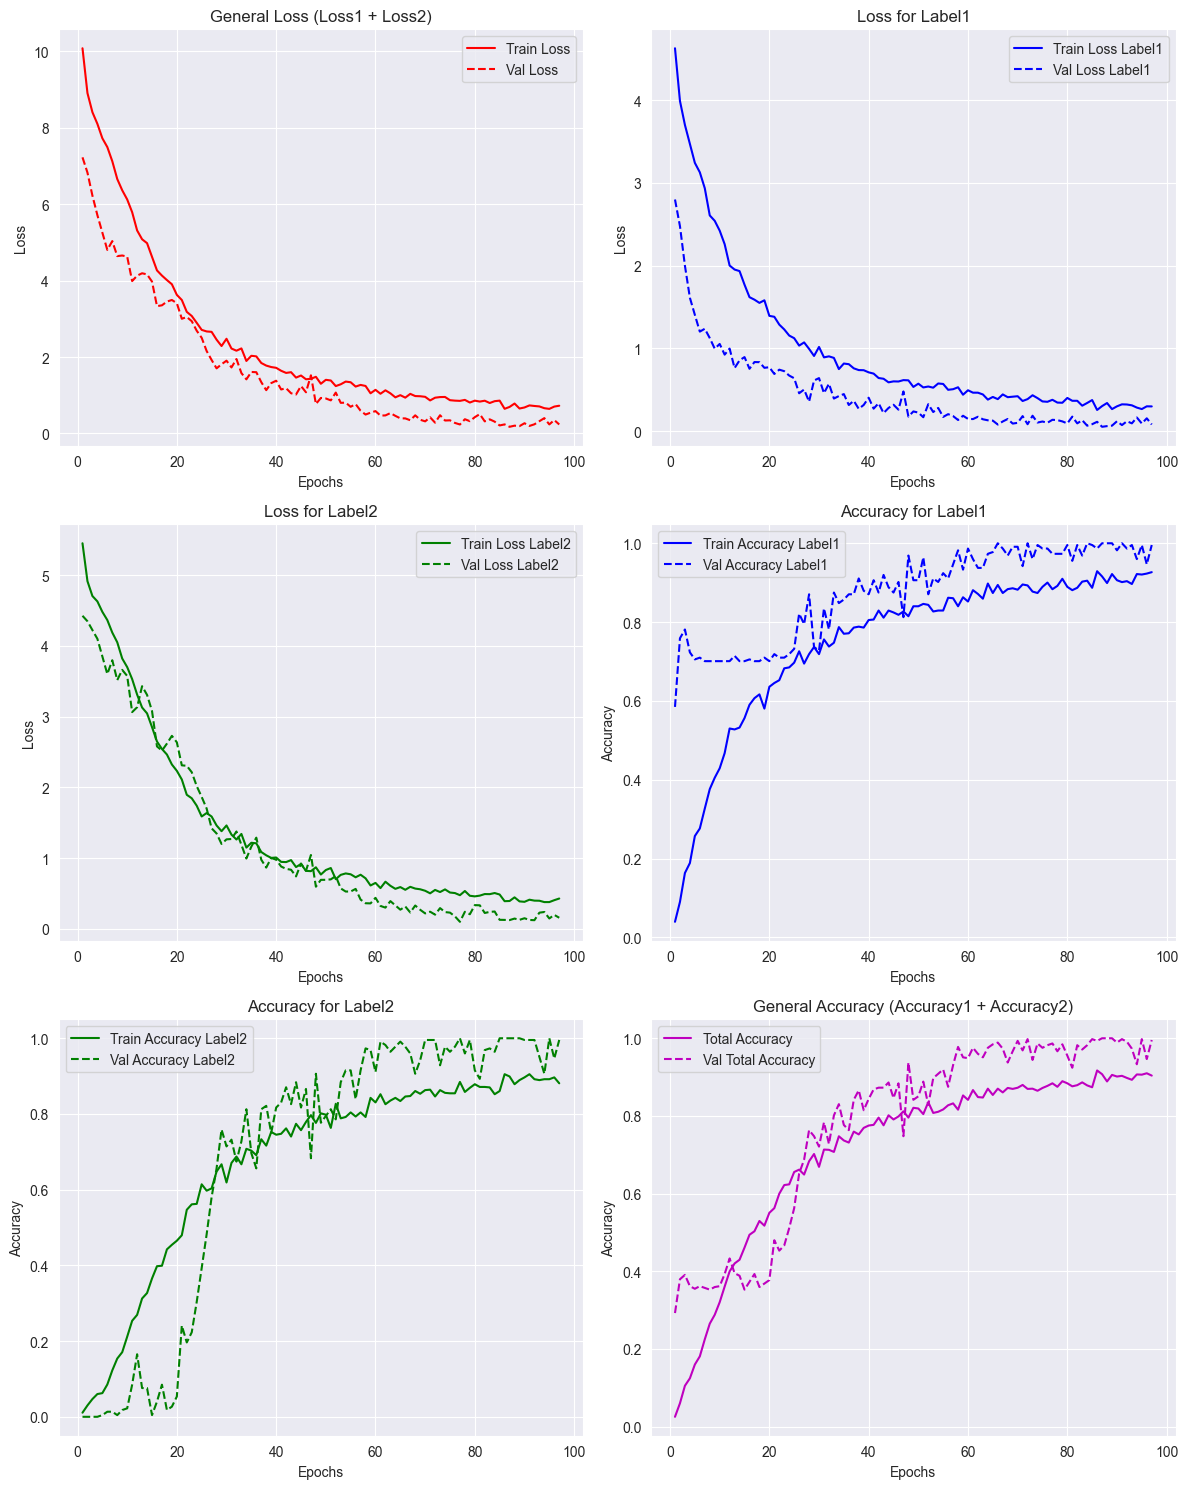

In [ ]:
if(os.path.exists('modelLastDatasetLearningRate.keras')):
    model = keras.models.load_model("modelLastDatasetLearningRate.keras")
else:
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 15))  # Aumento l'altezza per adattare più subplot

    # Grafico della Loss totale
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r-', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('General Loss (Loss1 + Loss2)')

    # Grafico della Loss Y1 (Fruit)
    plt.subplot(3, 2, 2)
    plt.plot(epochs, history.history['y1_loss'], 'b-', label='Train Loss Label1')
    plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Loss Label1')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss for Label1')

    # Grafico della Loss Y2 (Quality)
    plt.subplot(3, 2, 3)
    plt.plot(epochs, history.history['y2_loss'], 'g-', label='Train Loss Label2')
    plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Loss Label2')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss for Label2')

    # Grafico della Accuracy Y1 (Fruit)
    plt.subplot(3, 2, 4)
    plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Train Accuracy Label1')
    plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Accuracy Label1')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy for Label1')

    # Grafico della Accuracy Y2 (Quality)
    plt.subplot(3, 2, 5)
    plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Train Accuracy Label2')
    plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Accuracy Label2')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy for Label2')

    # Grafico della Accuracy Totale
    total_accuracy = (np.array(history.history['y1_accuracy']) + np.array(history.history['y2_accuracy'])) / 2
    val_total_accuracy = (np.array(history.history['val_y1_accuracy']) + np.array(history.history['val_y2_accuracy'])) / 2

    plt.subplot(3, 2, 6)
    plt.plot(epochs, total_accuracy, 'm-', label='Total Accuracy')
    plt.plot(epochs, val_total_accuracy, 'm--', label='Val Total Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('General Accuracy (Accuracy1 + Accuracy2)')

    plt.tight_layout()  # Migliora la disposizione dei grafici
    plt.show()

#### Salvataggio in memoria

In [ ]:
model.save("modelLastDatasetLearningRate.keras")

#### Valutazione metriche di classificazione

In [ ]:
score = model.evaluate(x_test_preprocessed, [y1_test, y2_test], verbose=1)

print(f"Test Loss Totale: {score[0]:.4f}")
print(f"Test Loss Y1 (Frutto): {score[1]:.4f}")
print(f"Test Loss Y2 (Qualità): {score[2]:.4f}")
print(f"Test Accuracy Y1 (Frutto): {score[3]:.4f}")
print(f"Test Accuracy Y2 (Qualità): {score[4]:.4f}")

440/440 ━━━━━━━━━━━━━━━━━━━━ 386s 867ms/step - loss: 0.5130 - y1_accuracy: 0.9467 - y1_loss: 0.1835 - y2_accuracy: 0.9295 - y2_loss: 0.3295
Test Loss Totale: 0.4855
Test Loss Y1 (Frutto): 0.2117
Test Loss Y2 (Qualità): 0.2732
Test Accuracy Y1 (Frutto): 0.9371
Test Accuracy Y2 (Qualità): 0.9408


In [ ]:
# Previsione delle probabilità per ciascun output
y1_pred, y2_pred = model.predict(x_test_preprocessed)

# Convertiamo le probabilità in etichette (classe con probabilità più alta)
y1_pred_classes = y1_pred.argmax(axis=1)
y2_pred_classes = y2_pred.argmax(axis=1)

y1_test_classes = y1_test.argmax(axis=1)
y2_test_classes = y2_test.argmax(axis=1)

# Report per la prima task (Frutto)
print("Classification Report - Y1 (Frutto):")
print(classification_report(y1_test_classes, y1_pred_classes))

# Report per la seconda task (Qualità)
print("Classification Report - Y2 (Qualità):")
print(classification_report(y2_test_classes, y2_pred_classes))

440/440 ━━━━━━━━━━━━━━━━━━━━ 348s 785ms/step
📊 Classification Report - Y1 (Frutto):
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1510
           1       0.91      0.90      0.90        98
           2       0.96      0.97      0.96       183
           3       0.96      0.96      0.96       286
           4       1.00      0.90      0.95        90
           5       0.98      0.91      0.94        92
           6       1.00      0.86      0.92        28
           7       0.98      0.85      0.91        98
           8       0.97      0.99      0.98       196
           9       1.00      0.92      0.96        98
          10       1.00      0.93      0.97        30
          11       0.97      1.00      0.98       140
          12       0.93      0.95      0.94       686
          13       0.97      0.84      0.90        90
          14       0.86      0.99      0.92        98
          15       0.94      0.98      0.96        

In [ ]:
# Report per la prima task (Frutto)
print("📊 Classification Report - Y1 (Frutto):")
y1_report = classification_report(y1_test_classes, y1_pred_classes, output_dict=True)
print(f"Precision: {y1_report['weighted avg']['precision']:.4f}")
print(f"Recall: {y1_report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {y1_report['weighted avg']['f1-score']:.4f}")

# Report per la seconda task (Qualità)
print("📊 Classification Report - Y2 (Qualità):")
y2_report = classification_report(y2_test_classes, y2_pred_classes, output_dict=True)
print(f"Precision: {y2_report['weighted avg']['precision']:.4f}")
print(f"Recall: {y2_report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {y2_report['weighted avg']['f1-score']:.4f}")

📊 Classification Report - Y1 (Frutto):
Precision: 0.9400
Recall: 0.9371
F1-Score: 0.9365
📊 Classification Report - Y2 (Qualità):
Precision: 0.9422
Recall: 0.9408
F1-Score: 0.9404


#### Visualizzazione errori su test interno

In [ ]:
def deprocess_resnet101(img):
    """Inverti la normalizzazione della ResNet101."""
    img = img.copy()
    img += np.array([103.939, 116.779, 123.68])  # Riaggiungi il valore medio
    img = img[..., ::-1]  # Converti da BGR a RGB
    return np.clip(img, 0, 255).astype(np.uint8)  # Clip e conversione a uint8

# Esempio di utilizzo
x_train_original = deprocess_resnet101(x_train_preprocessed)
x_val_original = deprocess_resnet101(x_val_preprocessed)
x_test_original = deprocess_resnet101(x_test_preprocessed)

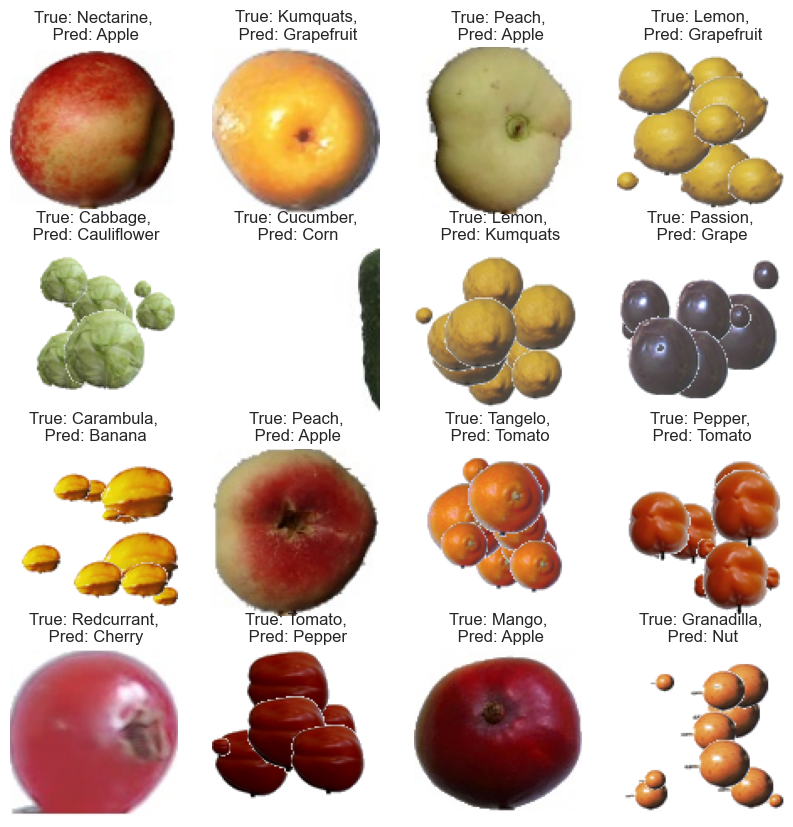

In [ ]:
# Trova gli indici degli errori
wrong_indices = np.where(y1_pred_classes != y1_test_classes)[0]

# Seleziona fino a 16 immagini casuali dagli errori
num_samples = min(16, len(wrong_indices))  # Evita errori se ci sono meno di 16 errori
random_wrong_indices = np.random.choice(wrong_indices, num_samples, replace=False)

# Mostra le immagini errate
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        idx = random_wrong_indices[i]
        
        # Controllo formato e normalizzazione
        img = np.clip(x_test_original[idx]/255, 0, 1)  # Assicura che plt.imshow() funzioni bene

        ax.imshow(img)
        ax.set_title(f"True: {labels_1_array[y1_test_classes[idx]]},\n Pred: {labels_1_array[y1_pred_classes[idx]]}")
    ax.axis("off")  # Nasconde gli assi per estetica

plt.show()

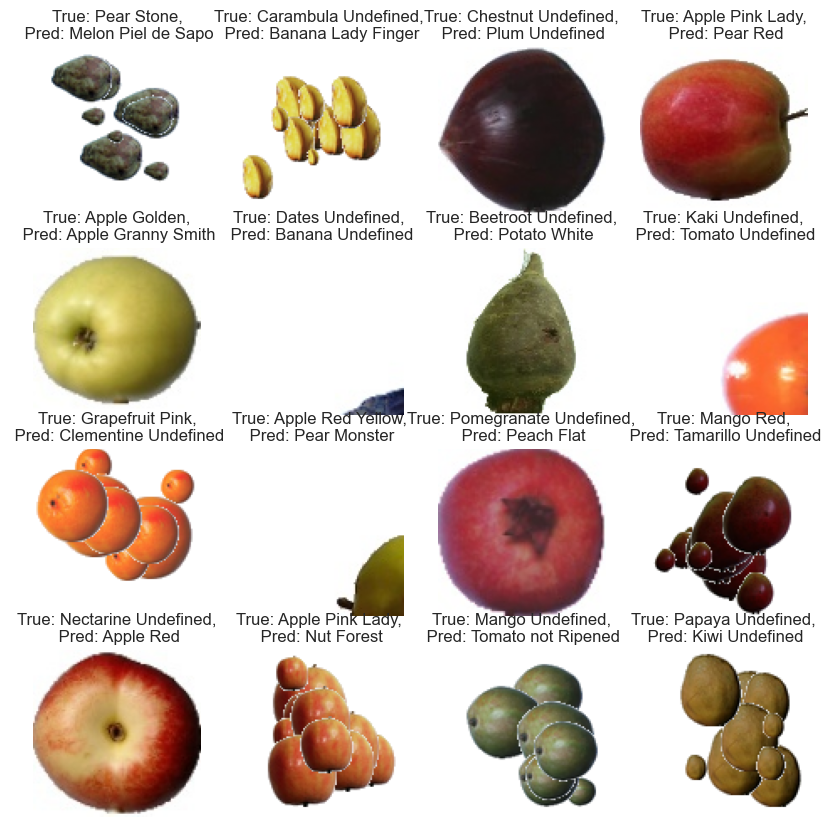

In [ ]:
# Trova gli indici degli errori
wrong_indices = np.where(y2_pred_classes != y2_test_classes)[0]

# Seleziona fino a 16 immagini casuali dagli errori
num_samples = min(16, len(wrong_indices))  # Evita errori se ci sono meno di 16 errori
random_wrong_indices = np.random.choice(wrong_indices, num_samples, replace=False)

# Mostra le immagini errate
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        idx = random_wrong_indices[i]
        
        # Controllo formato e normalizzazione
        img = np.clip(x_test_original[idx] / 255, 0, 1) # Assicura che plt.imshow() funzioni bene

        ax.imshow(img)
        ax.set_title(f"True: {labels_2_array[y2_test_classes[idx]]},\n Pred: {labels_2_array[y2_pred_classes[idx]]}")
    ax.axis("off")  # Nasconde gli assi per estetica

plt.show()

#### Valutazione Test esterno

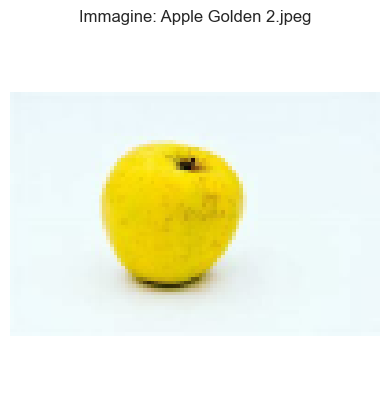

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Immagine: Apple Golden 2.jpeg, Predizione: Quince - Quince Undefined


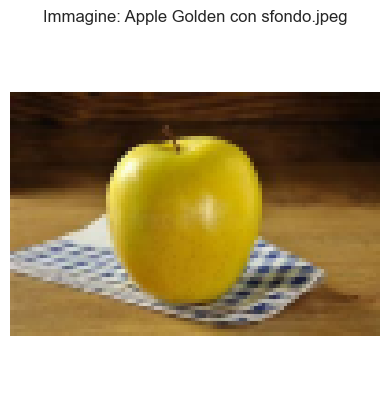

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Immagine: Apple Golden con sfondo.jpeg, Predizione: Physalis - Maracuja Undefined


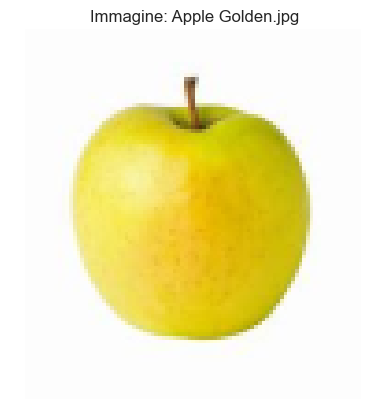

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Immagine: Apple Golden.jpg, Predizione: Apple - Pear Monster


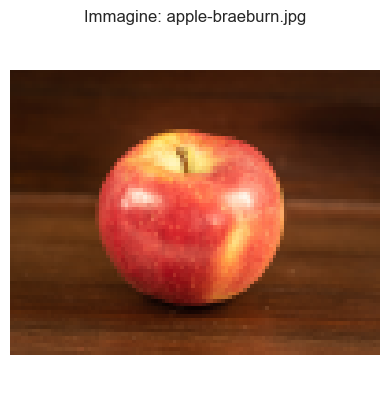

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Immagine: apple-braeburn.jpg, Predizione: Apple - Apple Red


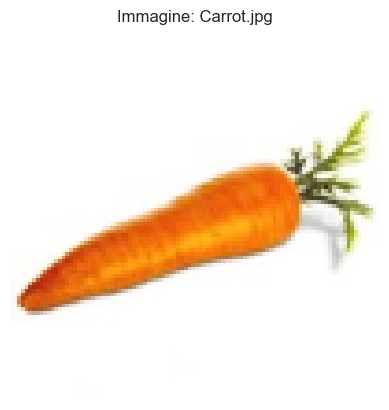

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Immagine: Carrot.jpg, Predizione: Banana - Banana Undefined


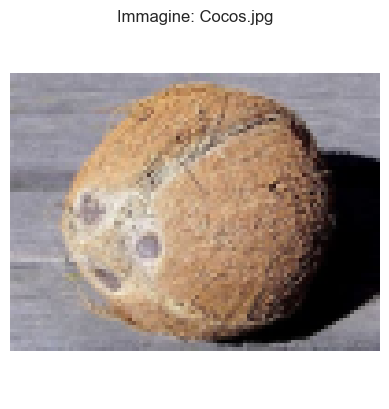

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Immagine: Cocos.jpg, Predizione: Kiwi - Kiwi Undefined


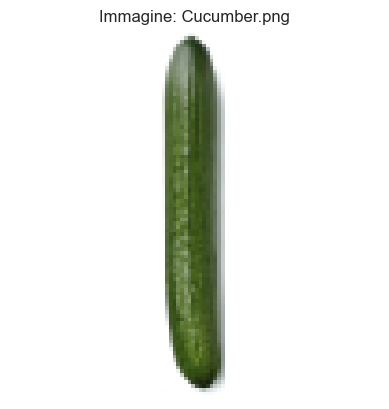

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Immagine: Cucumber.png, Predizione: Cucumber - Cucumber Undefined


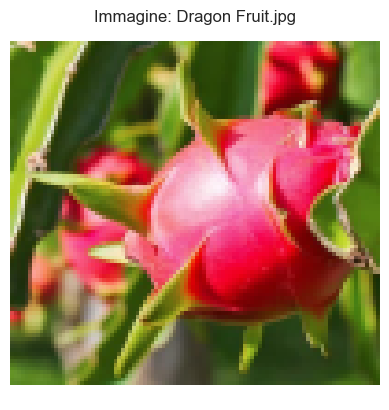

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Immagine: Dragon Fruit.jpg, Predizione: Pitahaya - Pitahaya Red


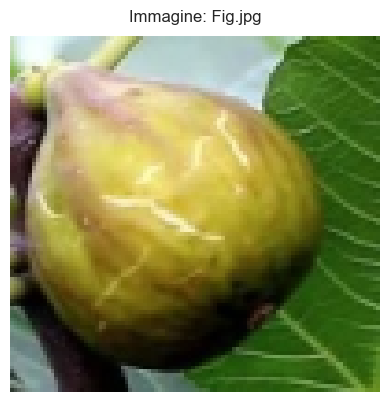

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Immagine: Fig.jpg, Predizione: Apple - Apple Red Yellow


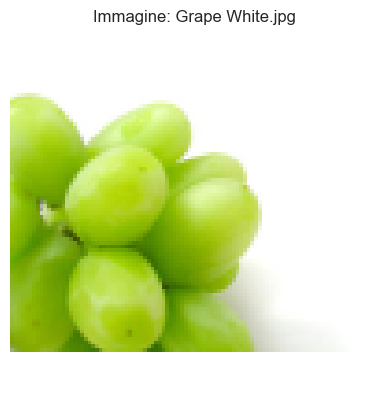

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Immagine: Grape White.jpg, Predizione: Apple - Apple Golden


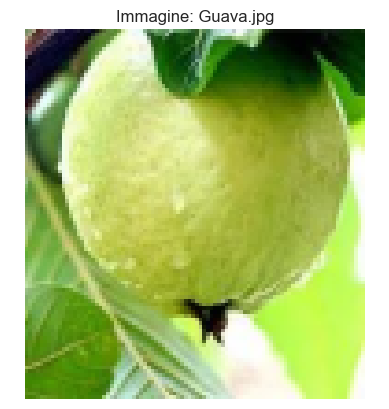

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Immagine: Guava.jpg, Predizione: Apple - Apple Red Yellow


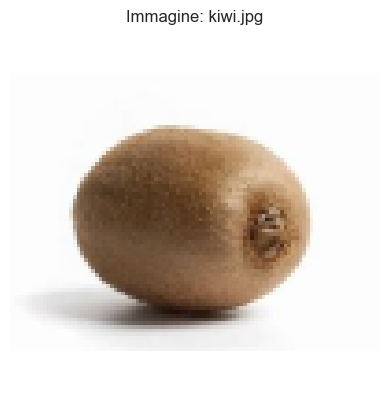

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Immagine: kiwi.jpg, Predizione: Pear - Pear Forelle


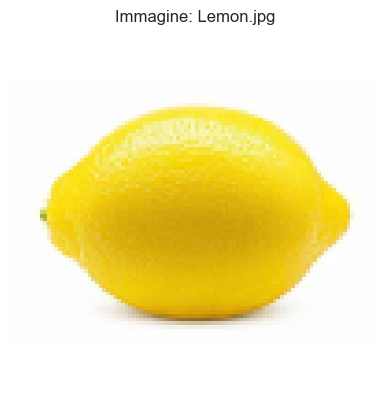

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Immagine: Lemon.jpg, Predizione: Lemon - Lemon Undefined


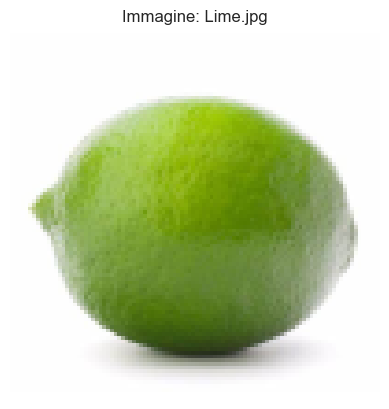

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Immagine: Lime.jpg, Predizione: Apple - Apple Red Yellow


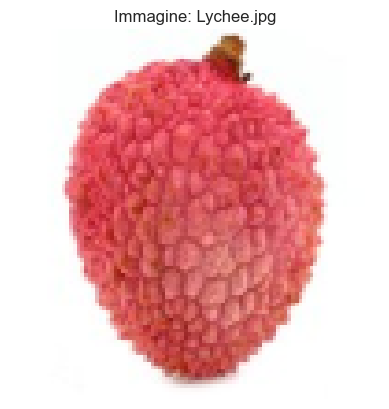

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Immagine: Lychee.jpg, Predizione: Strawberry - Strawberry Wedge


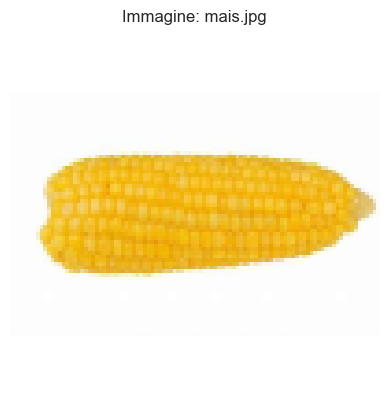

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Immagine: mais.jpg, Predizione: Corn - Corn Undefined


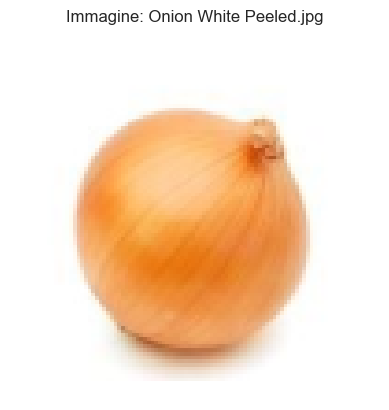

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Immagine: Onion White Peeled.jpg, Predizione: Onion - Onion White


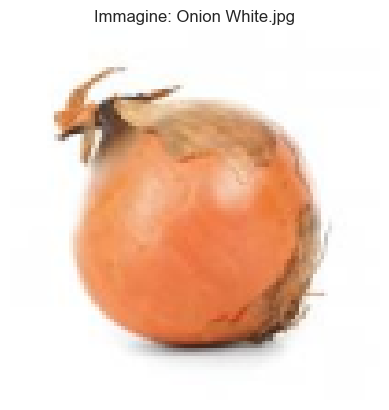

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Immagine: Onion White.jpg, Predizione: Granadilla - Clementine Undefined


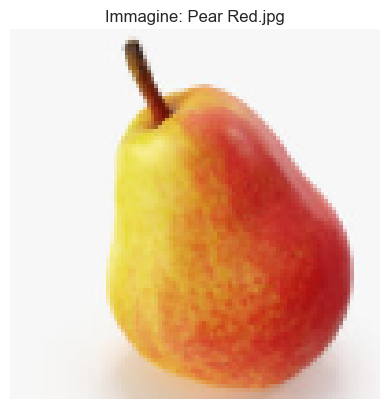

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Immagine: Pear Red.jpg, Predizione: Pear - Pear Red


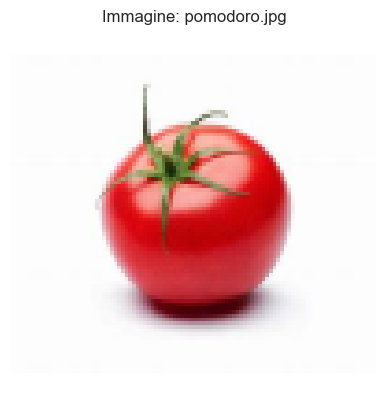

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Immagine: pomodoro.jpg, Predizione: Tomato - Tomato Undefined


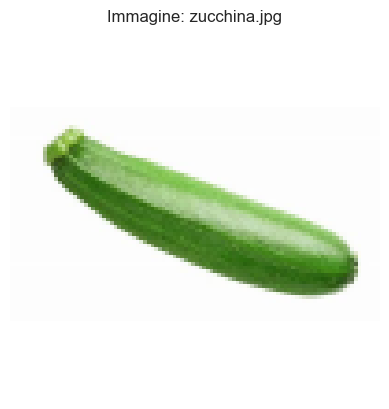

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Immagine: zucchina.jpg, Predizione: Corn - Corn Husk


In [ ]:
print("Ext Test: \n")
# Itera su tutte le immagini nella cartella
for nome_file in os.listdir(cartella_immagini):
    percorso_file = os.path.join(cartella_immagini, nome_file)

    # Controlla che sia un file immagine
    if not (nome_file.endswith(".jpg") or nome_file.endswith(".png") or nome_file.endswith(".jpeg")):
        continue

    # Carica l'immagine
    img = cv2.imread(percorso_file)
    img_resized = resize_image_keep_aspect_ratio(img)
    resized_img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img_resized / 255)
    plt.title(f"Immagine: {nome_file}")
    plt.axis("off")  # Rimuove gli assi per una visualizzazione più pulita
    plt.show()  # Mostra l'immagine immediatamente

    # Converti l'immagine in array numpy e applica il preprocessing di ResNet
    img_array = np.expand_dims(img_resized, axis=0).astype("float32")  # Aggiungi batch dimension
    img_preprocessed = tf.keras.applications.resnet.preprocess_input(img_array)  # Preprocess ResNet101

    # Predizione con il modello
    prediction = model.predict(img_preprocessed)
    # Supponiamo che `prediction` sia il risultato del modello

    # Estrai l'indice con la probabilità massima per entrambe le predizioni
    predicted_fruit_idx = np.argmax(prediction[0])  # Prima parte della predizione
    predicted_quality_idx = np.argmax(prediction[1])  # Seconda parte della predizione
    
    # Recupera i nomi dal dizionario o dalla lista
    predicted_fruit = labels_1_array[predicted_fruit_idx]
    predicted_quality = labels_2_array[predicted_quality_idx]
    
    # Stampa il risultato
    print(f"Immagine: {nome_file}, Predizione: {predicted_fruit} - {predicted_quality}")

### Modello 3: VGG19 + custom loss

#### Reload dateset

In [ ]:
x_train, y1_train, y2_train, x_val, y1_val, y2_val, x_test, y1_test, y2_test = reaload_from_scratch()

#### Normalizzazione dati:

In [ ]:
# Preprocessing per train
x_train = tf.keras.applications.vgg19.preprocess_input(x_train)

# Preprocessing per validation
x_val = tf.keras.applications.vgg19.preprocess_input(x_val)

# Preprocessing per test
x_test = tf.keras.applications.vgg19.preprocess_input(x_test)

#### Calcolo steps per epochs

In [ ]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])

In [ ]:
dataset_size = len(x_train)  # Numero totale di campioni
epochs_number = 30
batch_size = 16

steps_per_epoch = int(1.5 * dataset_size / batch_size / epochs_number)
steps_per_val = int(len(x_val) / batch_size / epochs_number)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Steps per val: {steps_per_val}")

Steps per epoch: 176
Steps per val: 49


#### Implementazione VGG19

In [ ]:
# Carica il modello VGG19 pre-addestrato
VGG_model = VGG19(
                weights='imagenet', 
                include_top=False, 
                input_shape=(100, 100, 3),
                input_tensor=None,
                pooling=None,
                classifier_activation="softmax"
            )

In [ ]:
VGG_model.trainable = False  # Blocca i pesi del modello pre-addestrato

In [ ]:
# Aggiungi strati personalizzati
x = GlobalAveragePooling2D()(VGG_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)

# Ramo 1 - Predizione del Frutto
fruit_output = Dense(num_classes_1, activation="softmax", name="y1")(x)

# Ramo 2 - Predizione della Qualità
quality_output = Dense(num_classes_2, activation="softmax", name="y2")(x)

In [ ]:
# Crea il modello con doppia uscita
model = Model(inputs=VGG_model.input, outputs=[fruit_output, quality_output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 100, 100,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 100, 100,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 50, 50,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 50, 50,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 50, 50,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 25, 25,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 25, 25,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 25, 25,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 25, 25,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 25, 25,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 12, 12,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 12, 12,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 12, 12,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 12, 12,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 12, 12,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 6, 6, 512) │          0 │ block4_conv4[0][

 Total params: 20,475,903 (78.11 MB)

 Trainable params: 451,519 (1.72 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

#### Loss custom

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def loss_fn(y_true, y_pred, alpha=1.5):
    """
    Loss function that penalizes inconsistent predictions between label1 and label2.
    """
    y1_classes = y_true.shape[1] // 2  # Supponiamo che y_true abbia tutte le classi concatenate

    # Separiamo le etichette principali (y1) e secondarie (y2)
    y1_true, y2_true = y_true[:, :y1_classes], y_true[:, y1_classes:]
    y1_pred, y2_pred = y_pred[:, :y1_classes], y_pred[:, y1_classes:]

    # Standard categorical cross-entropy loss per entrambe le etichette
    loss1 = tf.keras.losses.CategoricalCrossentropy()(y1_true, y1_pred)
    loss2 = tf.keras.losses.CategoricalCrossentropy()(y2_true, y2_pred)

    # Penalità per inconsistenza tra y1 e y2
    y1_y2_mismatch = tf.cast(tf.not_equal(tf.argmax(y1_pred, axis=-1), tf.argmax(y2_pred, axis=-1)), tf.float32)
    inconsistency_penalty = alpha * tf.reduce_mean(y1_y2_mismatch)

    # Loss finale
    return loss1 + loss2 + inconsistency_penalty


#### Train del modello

In [ ]:
# Definisci il numero di classi
num_classes_1 = len(y1_train[0])  # Classi dei frutti
num_classes_2 = len(y2_train[0])  # Classi della qualità

# Compila il modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),

    loss=loss_fn,

    metrics={
        'y1': 'accuracy', 
        'y2': 'accuracy'
        }
)

In [ ]:
if(os.path.exists('keras/model-VGG-AUG.keras')):
    model = load_model('keras/model-VGG-AUG.keras')
else:
    history = model.fit(
        x_train,
        {'y1': y1_train, 
        'y2': y2_train},
        validation_data=(
            x_val, {
                'y1': y1_val, 
                'y2': y2_val}),
        epochs=epochs_number,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_val
    )

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 96s 529ms/step - loss: 17.0573 - y1_accuracy: 0.0469 - y1_loss: 7.5200 - y2_accuracy: 0.0153 - y2_loss: 8.5212 - val_loss: 9.6767 - val_y1_accuracy: 0.4035 - val_y1_loss: 3.6811 - val_y2_accuracy: 0.0077 - val_y2_loss: 4.9884
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 429ms/step - loss: 11.1300 - y1_accuracy: 0.1348 - y1_loss: 4.5915 - y2_accuracy: 0.0433 - y2_loss: 5.5333 - val_loss: 7.9860 - val_y1_accuracy: 0.6425 - val_y1_loss: 2.6374 - val_y2_accuracy: 0.1393 - val_y2_loss: 4.3493
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 434ms/step - loss: 10.1869 - y1_accuracy: 0.2331 - y1_loss: 4.0041 - y2_accuracy: 0.0989 - y2_loss: 5.1853 - val_loss: 7.4142 - val_y1_accuracy: 0.6568 - val_y1_loss: 2.4097 - val_y2_accuracy: 0.3410 - val_y2_loss: 4.0123
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 431ms/step - loss: 9.4381 - y1_accuracy: 0.3039 - y1_loss: 3.6267 - y2_accuracy: 0.1312 - y2_loss: 4.8210 - val_loss: 7.0587 - val_y1_accuracy: 0.7971 - val_y

/Users/lucaperfetti/Desktop/università/Secondo Anno/Advanced ML/Project/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 4.9723 - y1_accuracy: 0.7821 - y1_loss: 1.8729 - y2_accuracy: 0.6743 - y2_loss: 2.1557 - val_loss: 4.7265 - val_y1_accuracy: 0.8081 - val_y1_loss: 1.7784 - val_y2_accuracy: 0.7105 - val_y2_loss: 2.0487
Epoch 22/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 426ms/step - loss: 4.6851 - y1_accuracy: 0.7243 - y1_loss: 1.8329 - y2_accuracy: 0.7289 - y2_loss: 1.9540 - val_loss: 4.6636 - val_y1_accuracy: 0.7621 - val_y1_loss: 1.7009 - val_y2_accuracy: 0.6974 - val_y2_loss: 2.0684
Epoch 23/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 426ms/step - loss: 4.5975 - y1_accuracy: 0.7550 - y1_loss: 1.7977 - y2_accuracy: 0.7443 - y2_loss: 1.9069 - val_loss: 4.7641 - val_y1_accuracy: 0.7906 - val_y1_loss: 1.6792 - val_y2_accuracy: 0.6327 - val_y2_loss: 2.1959
Epoch 24/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 427ms/step - loss: 4.5359 - y1_accuracy: 0.7664 - y1_loss: 1.7583 - y2_accuracy: 0.7549 - y2_loss: 1.8900 - val_loss: 4.6836 - val_y1_accuracy: 0.8026 - val_y1_loss: 1.6

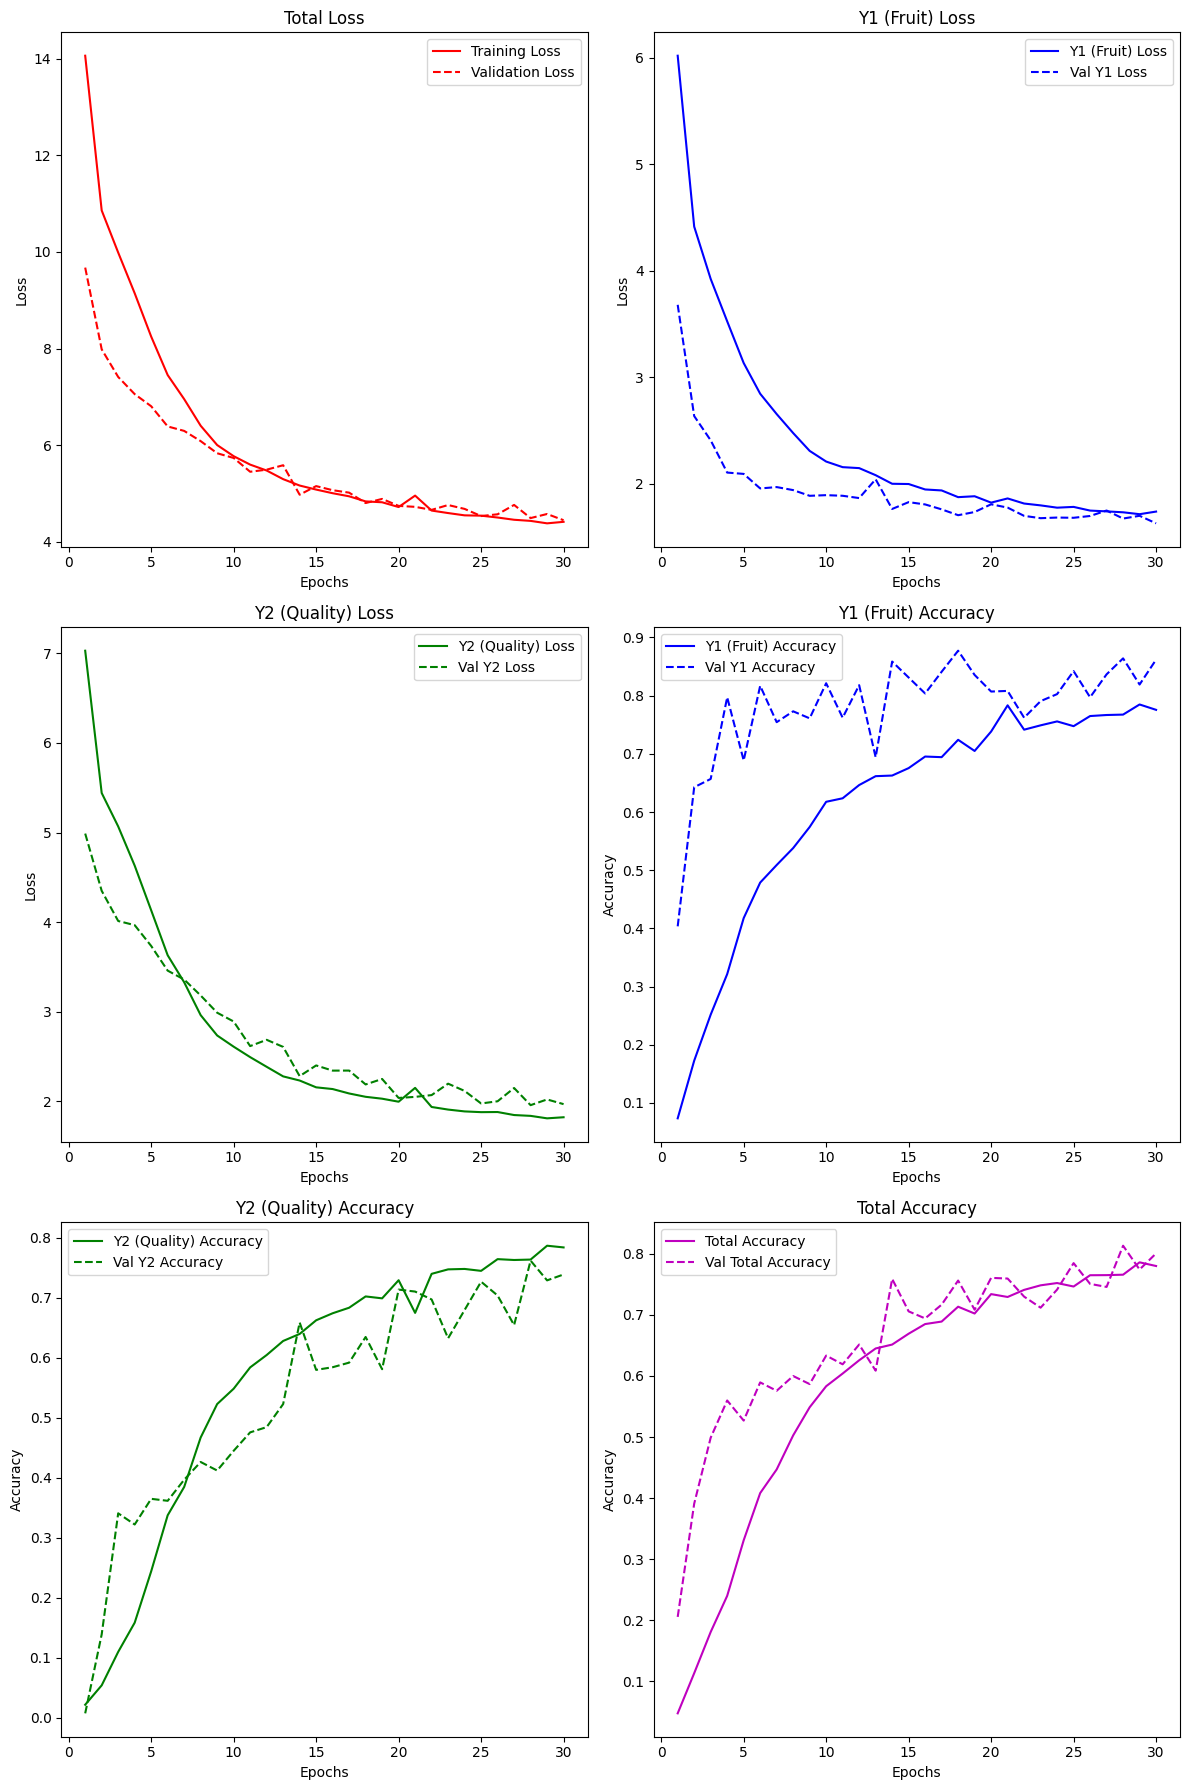

In [ ]:
# Dopo l'addestramento del modello
plot_training_history(history)

#### Salvataggio in memoria

In [ ]:
model.save("keras/model-VGG-AUG.keras")

In [ ]:
model = tf.keras.models.load_model(
    "keras/model-VGG-AUG.keras", 
    custom_objects={"loss_fn": loss_fn}
)

#### Valutazione metriche di classificazione

In [ ]:
y1_pred, y2_pred = model.predict(x_test)

y1_pred_classes = np.argmax(y1_pred, axis=1)
y2_pred_classes = np.argmax(y2_pred, axis=1)

y1_test_classes = np.argmax(y1_test, axis=1)
y2_test_classes = np.argmax(y2_test, axis=1)

440/440 ━━━━━━━━━━━━━━━━━━━━ 281s 638ms/step


In [ ]:
# Valutazione del modello sul test set
loss, loss_y1, loss_y2, acc_y1, acc_y2 = model.evaluate(x_test, {"y1": y1_test, "y2": y2_test}, verbose=0)

print(f"Loss Totale: {loss:.4f}")
print(f"Loss Y1 (Fruit): {loss_y1:.4f}")
print(f"Loss Y2 (Quality): {loss_y2:.4f}")
print(f"Accuracy Y1 (Fruit): {acc_y1:.4f}")
print(f"Accuracy Y2 (Quality): {acc_y2:.4f}")

Loss Totale: 4.1946
Loss Y1 (Fruit): 1.6351
Loss Y2 (Quality): 1.7078
Accuracy Y1 (Fruit): 0.8452
Accuracy Y2 (Quality): 0.8489


In [ ]:
#F1-score
y_pred_m1 = (y1_pred > 0.5).astype(int) 

f1 = f1_score(y1_test, y_pred_m1, average="weighted")
print(f'F1 Score: {f1}')

F1 Score: 0.8432390439141705


In [ ]:
#F1-score
y_pred_m2 = (y2_pred > 0.5).astype(int) 

f2 = f1_score(y2_test, y_pred_m2, average="weighted")
print(f'F1 Score: {f2}')

F1 Score: 0.8432510570633491


In [ ]:
print("Classification Report per Y1 (Frutto):")
print(classification_report(y1_test_classes, y1_pred_classes))

print("Classification Report per Y2 (Qualità):")
print(classification_report(y2_test_classes, y2_pred_classes))

📌 Classification Report per Y1 (Frutto):
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      1510
           1       0.83      0.96      0.89        98
           2       0.98      0.81      0.89       183
           3       0.98      0.96      0.97       286
           4       1.00      0.09      0.16        90
           5       0.85      0.25      0.39        92
           6       1.00      0.71      0.83        28
           7       1.00      0.50      0.67        98
           8       0.99      0.94      0.96       196
           9       0.90      0.88      0.89        98
          10       1.00      0.97      0.98        30
          11       0.99      0.94      0.96       140
          12       0.81      0.87      0.84       686
          13       0.71      0.88      0.78        90
          14       0.94      0.93      0.93        98
          15       1.00      0.87      0.93        98
          16       1.00      0.86      0

#### Visualizzazione errori su test interno

Si visualizzano su quali immagini la CNN fa' una predizione errata:

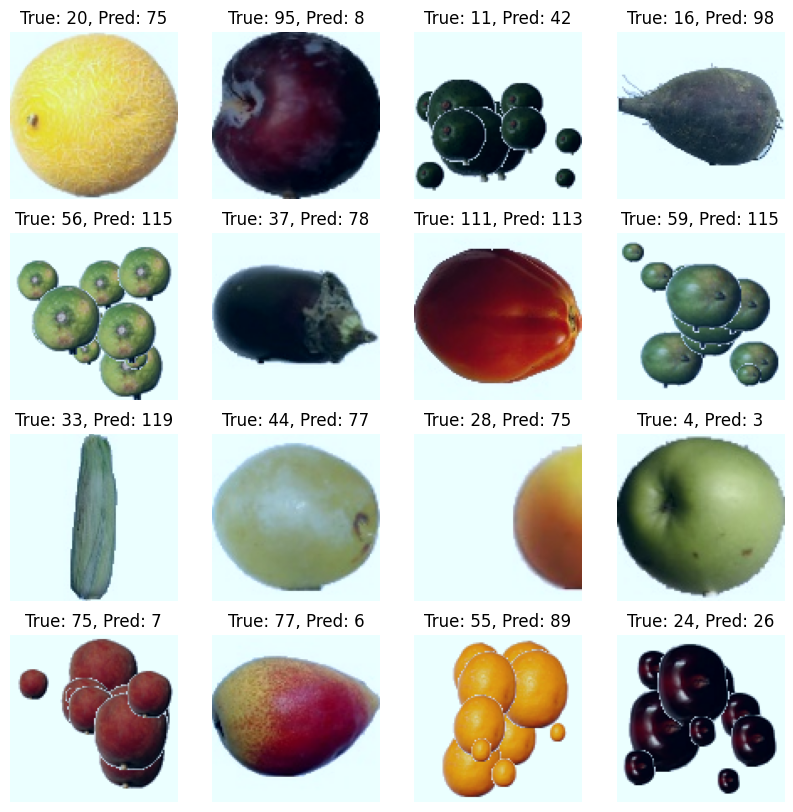

In [ ]:
# Trova gli indici degli errori
wrong_indices = np.where(y2_pred_classes != y2_test_classes)[0]

# Seleziona fino a 16 immagini casuali dagli errori
num_samples = min(16, len(wrong_indices))  # Evita errori se ci sono meno di 16 errori
random_wrong_indices = np.random.choice(wrong_indices, num_samples, replace=False)

# Mostra le immagini errate
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        idx = random_wrong_indices[i]

        # Ripristina i valori originali dell'immagine
        img = x_test[idx].copy()  # Copia per sicurezza
        img = img + [123.68, 116.78, 103.94]  # Riaggiunge la normalizzazione di VGG19
        img = np.clip(img, 0, 255).astype(np.uint8)  # Riporta a valori corretti

        # Converti da BGR a RGB
        img = img[..., ::-1]  

        ax.imshow(img)
        ax.set_title(f"True: {y2_test_classes[idx]}, Pred: {y2_pred_classes[idx]}")
    ax.axis("off")

plt.show()

#### Valutazione Test esterno

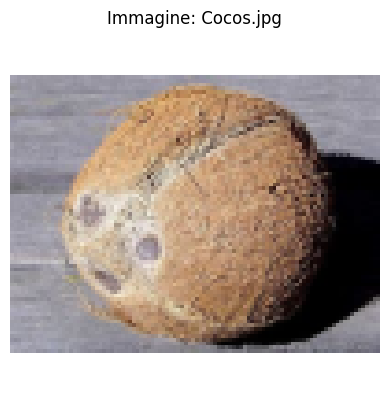

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Immagine: Cocos.jpg, Predizione: Peach - Peach Flat


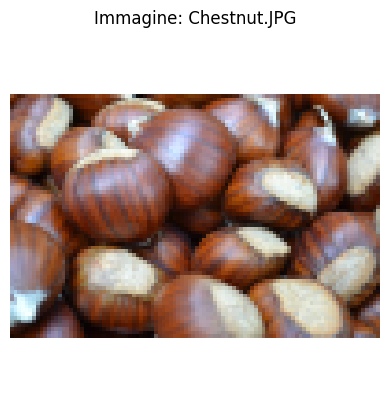

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Immagine: Chestnut.JPG, Predizione: Peach - Grape White


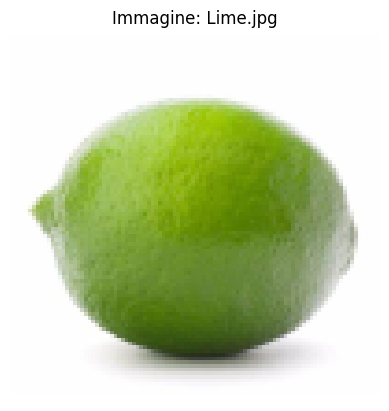

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Immagine: Lime.jpg, Predizione: Peach - Peach Flat


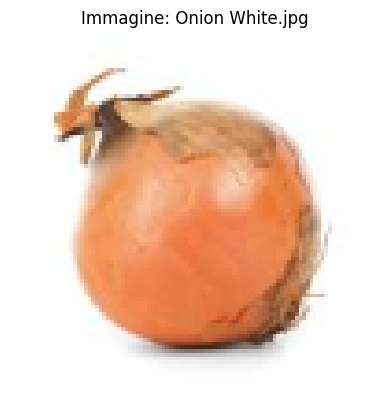

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Immagine: Onion White.jpg, Predizione: Peach - Peach Flat


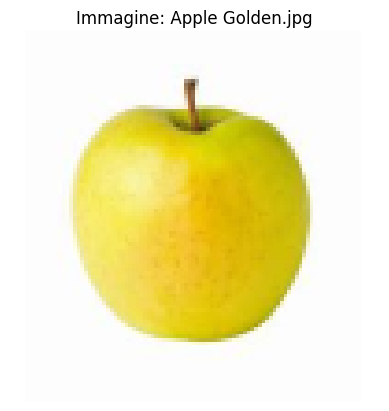

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Immagine: Apple Golden.jpg, Predizione: Peach - Peach Flat


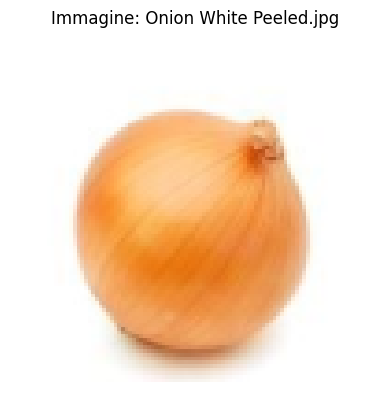

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Immagine: Onion White Peeled.jpg, Predizione: Peach - Peach Flat


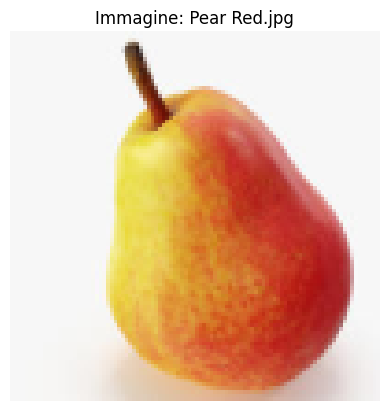

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Immagine: Pear Red.jpg, Predizione: Peach - Peach Flat


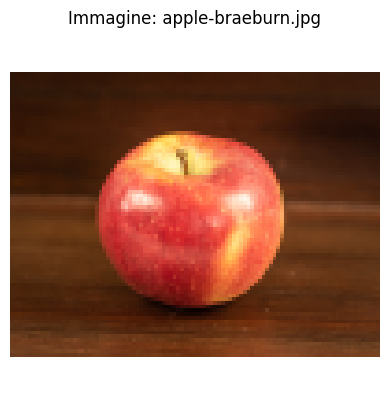

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Immagine: apple-braeburn.jpg, Predizione: Peach - Peach Flat


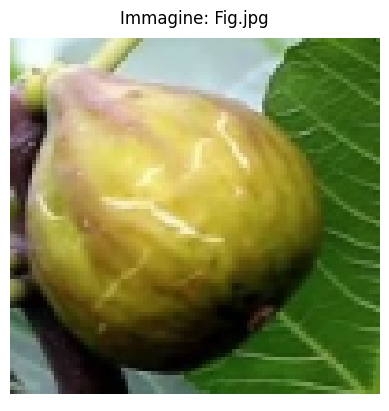

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Immagine: Fig.jpg, Predizione: Peach - Peach Flat


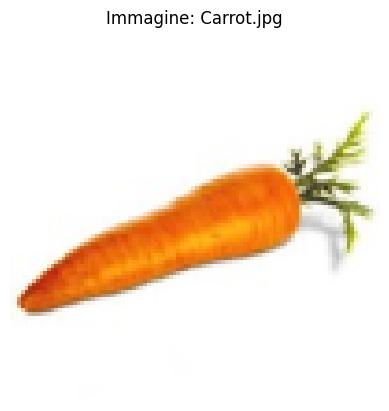

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Immagine: Carrot.jpg, Predizione: Peach - Peach Flat


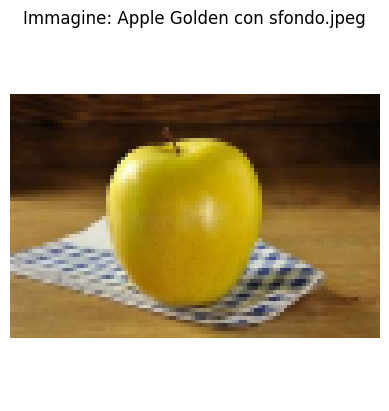

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Immagine: Apple Golden con sfondo.jpeg, Predizione: Peach - Grape White


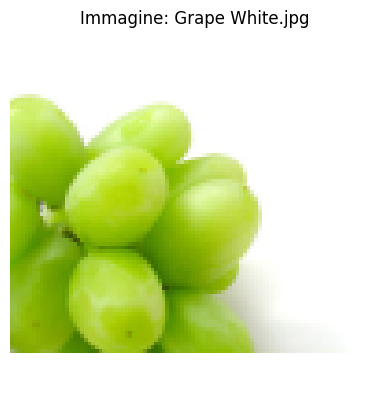

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Immagine: Grape White.jpg, Predizione: Peach - Peach Flat


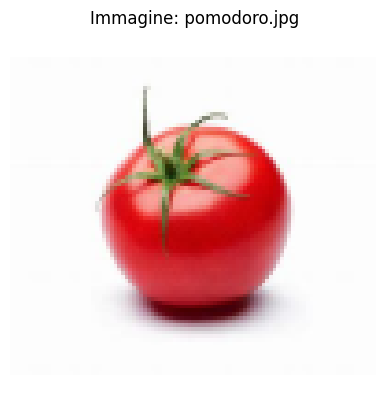

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Immagine: pomodoro.jpg, Predizione: Peach - Peach Flat


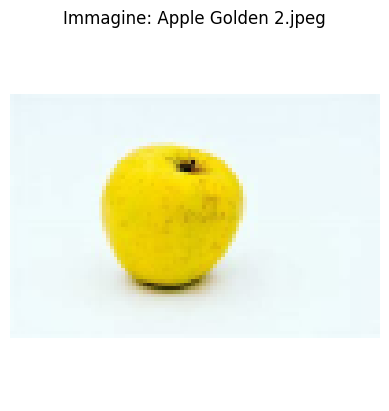

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Immagine: Apple Golden 2.jpeg, Predizione: Peach - Peach Flat


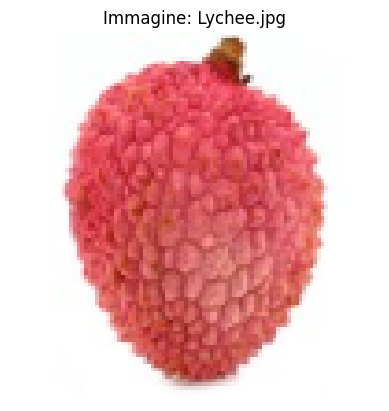

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Immagine: Lychee.jpg, Predizione: Peach - Peach Flat


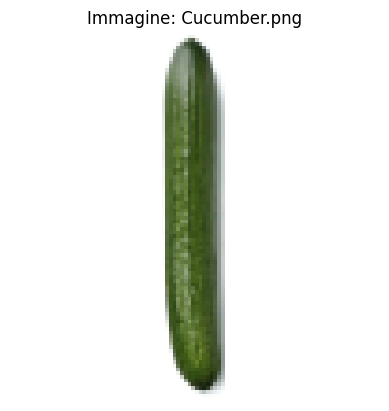

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Immagine: Cucumber.png, Predizione: Cucumber - Peach Flat


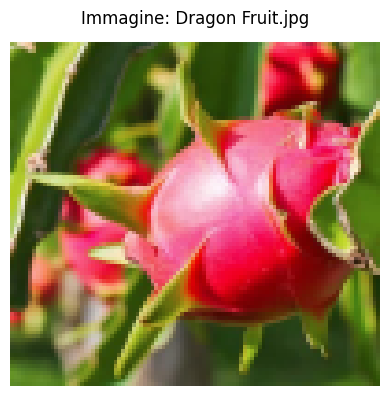

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Immagine: Dragon Fruit.jpg, Predizione: Peach - Peach Flat


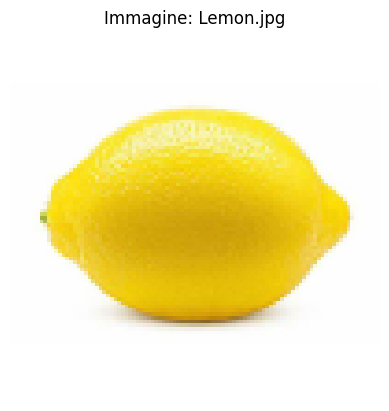

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Immagine: Lemon.jpg, Predizione: Peach - Peach Flat


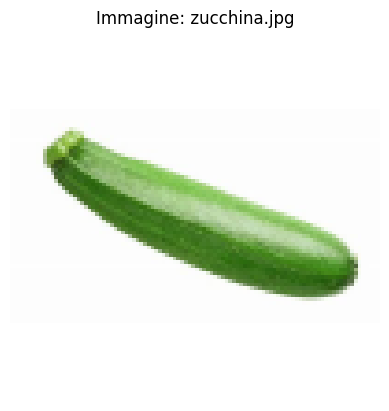

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Immagine: zucchina.jpg, Predizione: Peach - Peach Flat


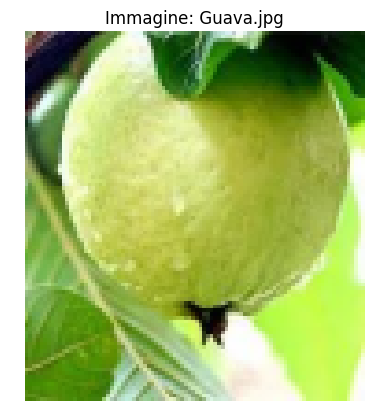

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Immagine: Guava.jpg, Predizione: Peach - Peach Flat


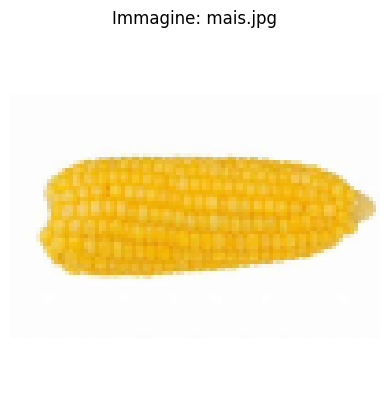

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Immagine: mais.jpg, Predizione: Peach - Peach Flat


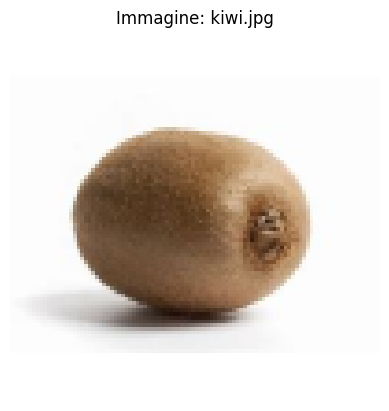

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Immagine: kiwi.jpg, Predizione: Peach - Peach Flat


In [ ]:
# Itera su tutte le immagini nella cartella
for nome_file in os.listdir(cartella_immagini):
    percorso_file = os.path.join(cartella_immagini, nome_file)

    # Controlla che sia un file immagine
    if not (nome_file.lower().endswith((".jpg", ".png", ".jpeg"))):
        continue

    # Carica l'immagine
    img = cv2.imread(percorso_file)
    if img is None:
        print(f"Errore nel caricamento di {nome_file}")
        continue

    img_resized = resize_image_keep_aspect_ratio(img)

    # Mostra l'immagine
    plt.imshow(img_resized / 255)  # Normalizzazione per la visualizzazione
    plt.title(f"Immagine: {nome_file}")
    plt.axis("off")
    plt.show()

    # Converti in array numpy e normalizza
    img_array = np.expand_dims(img_resized, axis=0).astype("float32") / 255.0  # Normalizzazione 0-1

    # Predizione con il modello custom
    prediction = model.predict(img_array)

    # Se il modello ha due output (frutta e qualità)
    predicted_fruit_idx = np.argmax(prediction[0])  # Output per la categoria frutta
    predicted_quality_idx = np.argmax(prediction[1])  # Output per la qualità

    # Recupera i nomi dai dizionari/liste delle etichette
    predicted_fruit = labels_1_array[predicted_fruit_idx]
    predicted_quality = labels_2_array[predicted_quality_idx]

    # Stampa il risultato
    print(f"Immagine: {nome_file}, Predizione: {predicted_fruit} - {predicted_quality}")


## Conclusioni

|               | Tempi di esecuzione | Accuracy | f1-score | Precisione sul test esterno |
| ------------- | ------------------- | -------- | -------- | --------------------------- |
| Baseline      | 20m                 | ~80%     | ~78%     | <20%                        |
| Siamese Model | 1:30h               | ~85%     | ~86%     | >20%                        |
| ResNet101     | 45m                 | ~94%     | ~94%     | ~50%                        |
| VGG19         | 43m                 | ~84%     | ~84%     | <20%                        |

Possiamo dunque concludere ritenendoci soddisfatti dei risultati ottenuti in quanto tutti molto inclini con le nostre aspettative. Infine possiamo decreatare il modello 2 (fine tune di resnet101 con loss tradizionale) come il più adeguato a risolvere problemi di multitask learning gerarchici. 